In [1]:
# Disable GPU
#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import os
import sys
import glob
import json
import pickle
import copy
import itertools
from functools import partial
from multiprocessing import Pool

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import skew, chi2, pearsonr
from scipy.spatial.distance import mahalanobis
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter, ScalarFormatter, MaxNLocator
import matplotlib.gridspec as gridspec

from IPython.display import Image, display

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from scipy import stats

import bayesflow as bf

import mvct_param_functions_or as prior_simulator_functions

2025-12-03 13:13:06.268443: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-03 13:13:06.293261: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-03 13:13:06.293280: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-03 13:13:06.293298: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-03 13:13:06.298016: I tensorflow/core/platform/cpu_feature_g

# Check Functions

In [3]:
params = prior_simulator_functions.levy_prior(False, 32)[1]
params

array([ 3.1481822 ,  1.3240628 ,  0.37189028, -0.8071951 ,  1.3384178 ,
        3.4900422 ,  1.120351  ], dtype=float32)

In [4]:
ndt, st0, zr, v0, v1, a, alpha = params
prior_simulator_functions.diffusion_trial(ndt, st0, zr, v0, a, alpha, False)

0.7451478617174923

In [5]:
prior_simulator_functions.ddm_simulator(params, 10, deadline=False)

array([[ 3.0230908 ,  0.        ],
       [-3.35417999,  0.        ],
       [-5.04566932,  0.        ],
       [-4.08701286,  0.        ],
       [-5.96317608,  0.        ],
       [ 5.30724943,  1.        ],
       [-4.09221511,  1.        ],
       [ 3.64432804,  1.        ],
       [ 6.28490528,  1.        ],
       [ 7.19675049,  1.        ]])

# Set Constants

In [6]:
# Generative model
PARAM_NAMES = ['t0', 'st0', 'zr', 'v0',  'v1', 'a', 'alpha']
PARAM_LABELS = [r"$t_0$", r"$s_{t_0}$", r"$z_r$", r"$v_{0}$", r"$v_{1}$", r"$a$", r"$\alpha$"]
PRIOR_CONTEXTS =  ["levy"]
model_map = {"levy": "Lévy-Flight"}
SIMULATOR_CONTEXTS = ["no_deadline"]

# Neural networks
NUM_ENSEMBLE_MEMBERS = 2
NUM_ITERATIONS_PER_EPOCH = 10000
BATCH_SIZE = 32
SUMMARY_NET_SETTINGS = {
    "summary_dim" : 20, #16,
    "num_dense_s1" : 3,
    "num_dense_s2" : 3,
    "num_dense_s3" : 3,
    "num_dense_equivariant" : 3
}

# Validation
NUM_COMBINATIONS = len(PRIOR_CONTEXTS) * len(SIMULATOR_CONTEXTS)
NUM_VAL_SIMS_PER_COMBINATION = 1000
NUM_VAL_SAMPLES = 150

NUM_EPOCHS = 125
TRAINING_MODE = "presimulation" #online
MY_NAME = "mvct_param_" + str(NUM_EPOCHS) + "ep"  

# Presimulation (irrelevant if online training is used)
RUNNER = "pc2" #"pc1"
PRESIM_PATH = "/media/administrator/Expansion/"
NUM_PROCESSES = 25 

FIG_PATH = "mvct/figures"
os.makedirs(FIG_PATH, exist_ok=True)
MY_DPI=600

tukey = 1.5
NUM_STUDIES = 2

print(MY_NAME)

mvct_param_125ep


# Generative Model

In [7]:
def binary_context_generator():
    """ 
    Generates binary context indicators for joint parameter estimation.
    Prior context: 0 = Levy, 1 = DDM.
    Simulator context: 0 = no deadline, 1 = deadline.
    """
    return np.random.binomial(n=1, p=0.5)
def prior_context_generator():
    """
    Generates a fixed context indicator based on the global PRIOR_CONTEXTS variable.
    Returns:
        int: Fixed context value (0 for "levy", 1 for "ddm").
    """
    return 0 if PRIOR_CONTEXTS == ["levy"] else 1
def simulator_context_generator():
    """
    Generates a fixed context indicator based on the global SIMULATOR_CONTEXTS variable.
    Returns:
        int: Fixed context value (0 for "no_deadline", 1 for "deadline").
    """
    return 0 if SIMULATOR_CONTEXTS == ["no_deadline"] else 1

In [8]:
if NUM_COMBINATIONS == 1:
    prior_fun = prior_context_generator
    simulator_fun = simulator_context_generator
elif NUM_COMBINATIONS == 2:
    prior_fun = prior_context_generator if len(PRIOR_CONTEXTS) == 1 else binary_context_generator
    simulator_fun = binary_context_generator if len(PRIOR_CONTEXTS) == 1 else simulator_context_generator
else: 
    prior_fun = simulator_fun = binary_context_generator

In [9]:
my_prior_context_generator = bf.simulation.ContextGenerator(non_batchable_context_fun=prior_fun)
my_simulator_context_generator = bf.simulation.ContextGenerator(non_batchable_context_fun=simulator_fun) if NUM_COMBINATIONS != 4 else my_prior_context_generator

prior = bf.simulation.Prior(
    batch_prior_fun=prior_simulator_functions.levy_prior, 
    context_generator=my_prior_context_generator,
    param_names=PARAM_NAMES
)

simulator = bf.simulation.Simulator(
    batch_simulator_fun=prior_simulator_functions.batch_simulator,
    context_generator=my_simulator_context_generator
)

generative_model = bf.simulation.GenerativeModel(prior=prior, simulator=simulator)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 7)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 349, 2)
INFO:root:Could not determine shape of prior non-batchable context. Type appears to be non-array: <class 'int'>,                                    so make sure your input configurator takes cares of that!
INFO:root:No optional prior batchable context provided.
INFO:root:Could not determine shape of simulation non-batchable context. Type appears to be non-array: <class 'int'>,                                    so make sure your input configurator takes cares of that!
INFO:root:No optional simulation batchable context provided.


In [10]:
prior(batch_size=2) 

{'prior_draws': array([[ 1.8311032 ,  0.02338212,  0.65808195,  0.49793154,  0.45388663,
          4.7017436 ,  1.8187597 ],
        [ 2.9887762 ,  0.62611425,  0.40228787, -1.8308082 ,  0.7234345 ,
          6.5884295 ,  1.7062013 ]], dtype=float32),
 'batchable_context': None,
 'non_batchable_context': 0}

In [11]:
sim_data = generative_model(batch_size=2)
sim_data

{'prior_non_batchable_context': 0,
 'prior_batchable_context': None,
 'prior_draws': array([[ 2.402299  ,  0.5124928 ,  0.7696328 ,  0.11945959,  1.0115019 ,
          0.81279266,  1.1361197 ],
        [ 3.9354477 ,  0.15774041,  0.53550136,  0.25687072, -0.37997368,
          3.6857395 ,  1.54285   ]], dtype=float32),
 'sim_non_batchable_context': 0,
 'sim_batchable_context': None,
 'sim_data': array([[[ 2.3832047,  0.       ],
         [ 3.1029634,  0.       ],
         [ 2.7918386,  0.       ],
         ...,
         [ 2.406093 ,  1.       ],
         [ 2.2008255,  1.       ],
         [-2.2777715,  1.       ]],
 
        [[ 7.800888 ,  0.       ],
         [ 6.022304 ,  0.       ],
         [ 8.202351 ,  0.       ],
         ...,
         [-5.509007 ,  1.       ],
         [-4.605864 ,  1.       ],
         [ 5.2560463,  1.       ]]], dtype=float32)}

# Prior Checks

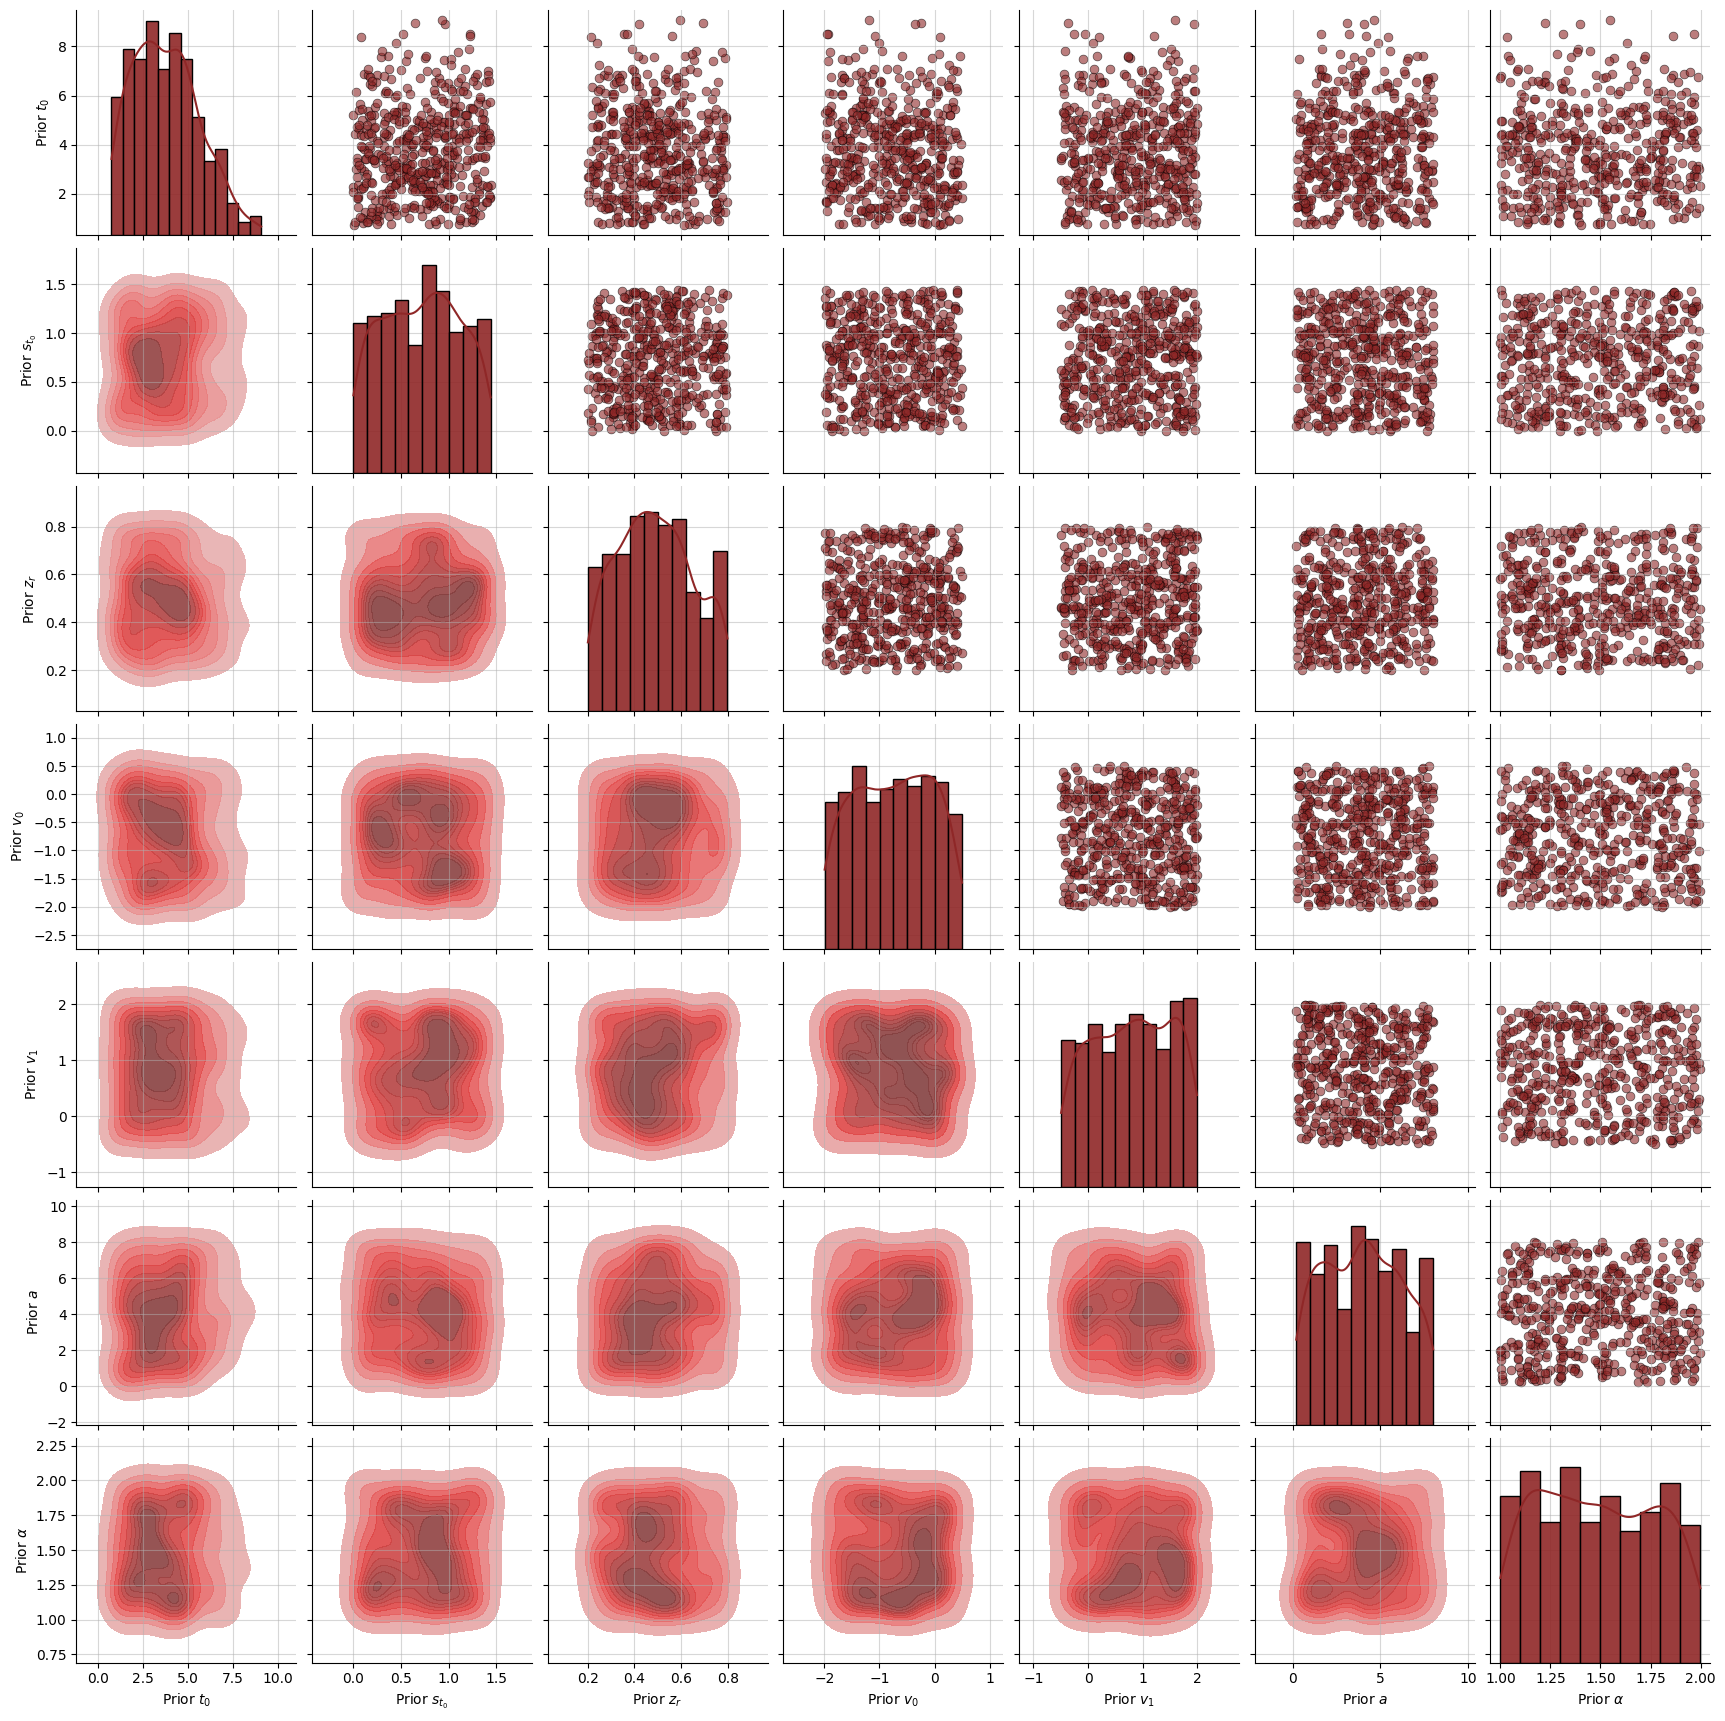

In [12]:
check_levy_prior = bf.simulation.Prior(
    batch_prior_fun=prior_simulator_functions.levy_prior, 
    context_generator=bf.simulation.ContextGenerator(non_batchable_context_fun=lambda: 0),
    param_names=PARAM_LABELS)
plot = check_levy_prior.plot_prior2d(n_samples=500)

# Prior Push Forward Check

In [13]:
if NUM_COMBINATIONS == 1:
    context_combinations = [(prior_context_generator(), simulator_context_generator())]
elif NUM_COMBINATIONS == 2:
    if len(PRIOR_CONTEXTS) == 1:
        context_combinations = [(prior_context_generator(), sim_context) for sim_context in range(len(SIMULATOR_CONTEXTS))]
    else:
        context_combinations = [(prior_context, simulator_context_generator()) for prior_context in range(len(PRIOR_CONTEXTS))]
else:
    context_combinations = list(itertools.product(range(len(PRIOR_CONTEXTS)), range(len(SIMULATOR_CONTEXTS))))

In [14]:
my_batch_size = 500  
all_rows = []

for prior_context, sim_context in context_combinations:
    check_prior = bf.simulation.Prior(
        batch_prior_fun=prior_simulator_functions.levy_prior,
        context_generator=bf.simulation.ContextGenerator(non_batchable_context_fun=lambda: prior_context),
        param_names=PARAM_NAMES
    )
    check_simulator = bf.simulation.Simulator(
        batch_simulator_fun=prior_simulator_functions.batch_simulator,
        context_generator=bf.simulation.ContextGenerator(non_batchable_context_fun=lambda: sim_context)
    )

    check_generative_model = bf.simulation.GenerativeModel(prior=check_prior, simulator=check_simulator)
    sim_rts = check_generative_model(batch_size=my_batch_size)['sim_data']  

    df = pd.DataFrame({
        'pp': np.repeat(np.arange(my_batch_size), sim_rts.shape[1]),
        'RT': sim_rts[:, :, 0].flatten(),
        'symbol': sim_rts[:, :, 1].astype(int).flatten(),
        'prior': prior_context,
        'simulator': sim_context
    })

    cond1 = (df['RT'] < 0) & (df['symbol'] == 1)
    cond2 = (df['RT'] > 0) & (df['symbol'] == 1)
    cond3 = (df['RT'] < 0) & (df['symbol'] == 0)
    cond4 = (df['RT'] > 0) & (df['symbol'] == 0)

    df['correct'] = np.nan
    df.loc[cond1, 'correct'] = 0
    df.loc[cond2, 'correct'] = 1
    df.loc[cond3, 'correct'] = 1
    df.loc[cond4, 'correct'] = 0
    df['correct'] = df['correct'].astype('Int64')

    df.loc[df['RT'] == 0, 'RT'] = np.nan
    df['RT'] = abs(df['RT'])

    for pp, group in df.groupby('pp'):
        RTs_correct = group.loc[group['correct'] == 1, 'RT']
        RTs_incorrect = group.loc[group['correct'] == 0, 'RT']
        
        mean_corr = RTs_correct.mean() if not RTs_correct.empty else np.nan
        mean_incorr = RTs_incorrect.mean() if not RTs_incorrect.empty else np.nan  
        mean_diff = mean_corr - mean_incorr if pd.notnull(mean_corr) and pd.notnull(mean_incorr) else np.nan

        skew_corr = skew(RTs_correct, bias=False) if RTs_correct.size > 2 else np.nan
        skew_incorr = skew(RTs_incorrect, bias=False) if RTs_incorrect.size > 2 else np.nan

        acc = group['correct'].mean()
        prop_timeout = group['RT'].isna().mean()
        
        all_rows.append({
            'prior': prior_context,
            'simulator': sim_context,
            'pp': pp,
            'meanRT_corr': mean_corr,
            'meanRT_incorr': mean_incorr,
            'meanRT_diff': mean_diff,
            'skew_corr': skew_corr,
            'skew_incorr': skew_incorr,
            'acc': acc,
            'prop_timeout': prop_timeout
        })

df_results = pd.DataFrame(all_rows)

df_results['is_sym_corr'] = df_results['skew_corr'].between(-1, 1)
df_results['is_sym_incorr'] = df_results['skew_incorr'].between(-1, 1)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 7)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 346, 2)
INFO:root:Could not determine shape of prior non-batchable context. Type appears to be non-array: <class 'int'>,                                    so make sure your input configurator takes cares of that!
INFO:root:No optional prior batchable context provided.
INFO:root:Could not determine shape of simulation non-batchable context. Type appears to be non-array: <class 'int'>,                                    so make sure your input configurator takes cares of that!
INFO:root:No optional simulation batchable context provided.


In [15]:
my_vars = ['pp', 'prior', 'simulator', 'prop_timeout', 'is_sym_corr', 'acc']

df_rt = pd.melt(df_results, id_vars=my_vars, value_vars=['meanRT_corr', 'meanRT_incorr'], var_name='corr', value_name='rt')
df_rt['corr'] = df_rt['corr'].str.replace('meanRT_', '')

df_skew = pd.melt(df_results, id_vars=my_vars, value_vars=['skew_corr', 'skew_incorr'], var_name='corr', value_name='skew')
df_skew['corr'] = df_skew['corr'].str.replace('skew_', '')

df_long = pd.merge(df_rt, df_skew, on=my_vars + ['corr'])

In [16]:
min_corr = df_long[df_long['corr'] == 'corr']['rt'].min()
max_corr = df_long[df_long['corr'] == 'corr']['rt'].max()
min_incorr = df_long[df_long['corr'] == 'incorr']['rt'].min()
max_incorr = df_long[df_long['corr'] == 'incorr']['rt'].max()
min_rt = min(min_corr, min_incorr)
max_rt = max(max_corr, max_incorr)

min_corr = df_long[df_long['corr'] == 'corr']['skew'].min()
max_corr = df_long[df_long['corr'] == 'corr']['skew'].max()
min_incorr = df_long[df_long['corr'] == 'incorr']['skew'].min()
max_incorr = df_long[df_long['corr'] == 'incorr']['skew'].max()
min_skew = min(min_corr, min_incorr)
max_skew = max(max_corr, max_incorr)

min_acc = df_long[df_long['corr'] == 'corr']['acc'].min()
max_acc = df_long[df_long['corr'] == 'corr']['acc'].max()

In [17]:
def apa_tick_formatter(digits=1):
    def formatter(x, _):
        if x == int(x):
            if x >= 0:
                return str(int(x))
            else:
                return '−' + str(int(abs(x)))
        else:
            formatted = f'{abs(x):.{digits}f}'  
            trimmed = formatted.lstrip('0')
            if x < 0:
                return '−' + trimmed
            else:
                return trimmed
    return formatter

In [18]:
prior_map = {0: "Simple Lévy-Flight Model", 1: "Simple Diffusion Model"}
simulator_map = {0: "Absent", 1: "Present"}
combinations = df_long[['prior', 'simulator']].drop_duplicates().sort_values(['prior', 'simulator']).values

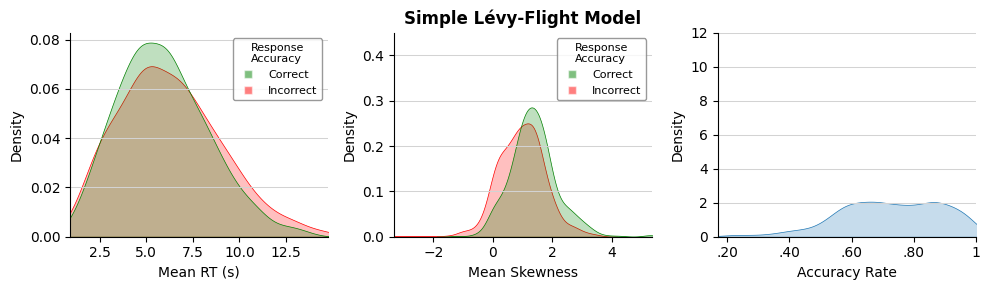

In [19]:
n_rows = len(combinations)
fig, axs = plt.subplots(n_rows, 3, figsize=(10, 3 * n_rows), sharex=0)

if n_rows == 1:
    axs = [axs]

for i, (prior_val, sim_val) in enumerate(combinations):
    subset = df_long[(df_long['prior'] == prior_val) & (df_long['simulator'] == sim_val)]
    prior_label = prior_map[prior_val]
    simulator_label = simulator_map[sim_val]
    #print("Timeout Modeling: ", simulator_label)

    # RT plot 
    sns.kdeplot(
        data=subset, x='rt', hue='corr', ax=axs[i][0],
        fill=True, lw=0.5, palette={'corr': 'green', 'incorr': 'red'}, legend=0
    )
    axs[i][0].grid(True, axis='y', color='lightgrey', linestyle='-', linewidth=0.75, zorder=0)
    axs[i][0].spines['top'].set_visible(False)
    axs[i][0].spines['right'].set_visible(False)
    axs[i][0].set_xlim([min_rt, max_rt])
    axs[i][0].set_xlabel('Mean RT (s)')

    legend_items = [mlines.Line2D([0], [0], marker='s', color='w', label="Correct",
                                  markerfacecolor="green", 
                                  #markersize=my_marker_size, 
                                  alpha=0.5),
                    mlines.Line2D([0], [0], marker='s', color='w', label="Incorrect",
                                  markerfacecolor="red", 
                                  #markersize=my_marker_size, 
                                  alpha=0.5)]
    legend = axs[i][0].legend(handles=legend_items, title='Response\nAccuracy',
                     loc='upper right', frameon=True,
                     facecolor='white', edgecolor='gray', fontsize=8)
    legend.get_title().set_fontsize(8)

    # Skewness plot
    sns.kdeplot(
        data=subset, x='skew', hue='corr', ax=axs[i][1],
        fill=True, lw=0.5, palette={'corr': 'green', 'incorr': 'red'}, legend=False
    )
    axs[i][1].set_title(f'{prior_label}', fontweight="bold")
    axs[i][1].grid(True, axis='y', color='lightgrey', linestyle='-', linewidth=0.75, zorder=0)
    axs[i][1].spines['top'].set_visible(False)
    axs[i][1].spines['right'].set_visible(False)
    axs[i][1].set_xlim([min_skew, max_skew])
    axs[i][1].set_ylim([0, .45])
    axs[i][1].set_xlabel('Mean Skewness')

    legend = axs[i][1].legend(handles=legend_items, title='Response\nAccuracy',
                     loc='upper right', frameon=True,
                     facecolor='white', edgecolor='gray', fontsize=8)
    legend.get_title().set_fontsize(8)

    # Accuracy plot
    sns.kdeplot(
        data=subset, x='acc', ax=axs[i][2], fill=True, lw=0.5, legend=False
    )
    axs[i][2].grid(True, axis='y', color='lightgrey', linestyle='-', linewidth=0.75, zorder=0)
    axs[i][2].spines['top'].set_visible(False)
    axs[i][2].spines['right'].set_visible(False)
    axs[i][2].set_xlim([min_acc, max_acc])
    axs[i][2].set_ylim([0, 12])
    axs[i][2].set_xlabel('Accuracy Rate')
    axs[i][2].xaxis.set_major_formatter(FuncFormatter(apa_tick_formatter(digits=2)))

plt.tight_layout()
plt.show()

# Configurator

In [20]:
def configurator(forward_dict):
    """Configure the output of the generative model for BayesFlow."""

    batch_size = forward_dict["sim_data"].shape[0]
    out_dict = {}
    out_dict["summary_conditions"] = forward_dict["sim_data"]
    vec_ones = np.ones((batch_size, 1)).astype(np.float32)
    vec_num_obs = np.sqrt(forward_dict["sim_data"].shape[1]) * vec_ones
    vec_prior_context = forward_dict["prior_non_batchable_context"] * vec_ones
    vec_sim_context = forward_dict["sim_non_batchable_context"] * vec_ones
    out_dict["direct_conditions"] = np.concatenate([vec_num_obs, vec_prior_context, vec_sim_context], axis=1)

    out_dict["parameters"] = forward_dict["prior_draws"].copy()
    if np.any(forward_dict["prior_non_batchable_context"]):  
        out_dict["parameters"][:, -1] = np.random.normal(loc=0.0, scale=1.0, size=batch_size)

    return out_dict

In [21]:
print(sim_data["prior_draws"])
configurator(sim_data)

[[ 2.402299    0.5124928   0.7696328   0.11945959  1.0115019   0.81279266
   1.1361197 ]
 [ 3.9354477   0.15774041  0.53550136  0.25687072 -0.37997368  3.6857395
   1.54285   ]]


{'summary_conditions': array([[[ 2.3832047,  0.       ],
         [ 3.1029634,  0.       ],
         [ 2.7918386,  0.       ],
         ...,
         [ 2.406093 ,  1.       ],
         [ 2.2008255,  1.       ],
         [-2.2777715,  1.       ]],
 
        [[ 7.800888 ,  0.       ],
         [ 6.022304 ,  0.       ],
         [ 8.202351 ,  0.       ],
         ...,
         [-5.509007 ,  1.       ],
         [-4.605864 ,  1.       ],
         [ 5.2560463,  1.       ]]], dtype=float32),
 'direct_conditions': array([[18.330303,  0.      ,  0.      ],
        [18.330303,  0.      ,  0.      ]], dtype=float32),
 'parameters': array([[ 2.402299  ,  0.5124928 ,  0.7696328 ,  0.11945959,  1.0115019 ,
          0.81279266,  1.1361197 ],
        [ 3.9354477 ,  0.15774041,  0.53550136,  0.25687072, -0.37997368,
          3.6857395 ,  1.54285   ]], dtype=float32)}

# Neural Network Training

## Pre Training

In [22]:
def f(x, presim_path):
    file_path = os.path.join(presim_path, f'presim_file_{x}.pkl')
    
    with open(file_path, 'wb+') as file:
        for k in range(NUM_ITERATIONS_PER_EPOCH):
            presim_res = generative_model(BATCH_SIZE)
            pickle.dump(presim_res, file)

def f2(x, presim_path='sims'):
    file_list = [{} for _ in range(NUM_ITERATIONS_PER_EPOCH)]
    for k in range(NUM_ITERATIONS_PER_EPOCH):
        file_list[k] = generative_model(BATCH_SIZE)  
        
    file_path = f'{presim_path}/presim_file_{x}.pkl'

    with open(file_path, 'wb+') as f:
        pickle.dump(file_list, f)

def multipickle_loader(file_path):
    sim_dicts = []

    with open(file_path, 'rb') as f:
        try:
            while True:
                sim_dicts.append(pickle.load(f))
        except EOFError:
            pass
            
    return sim_dicts

In [23]:
def setup_network(
    checkpoint_path,
    input_dim=2,
    summary_net_settings=SUMMARY_NET_SETTINGS,
    param_names=PARAM_NAMES,
    num_coupling_layers=9,
    coupling_design="spline",
    generative_model=generative_model,
    configurator=configurator,
    learning_rate=0.0001 #0.00025
):
    tf.keras.backend.clear_session()
    summary_net = bf.networks.DeepSet(
        summary_dim = summary_net_settings["summary_dim"],
        num_dense_s1 = summary_net_settings["num_dense_s1"],
        num_dense_s2 = summary_net_settings["num_dense_s2"],
        num_dense_s3 = summary_net_settings["num_dense_s3"],
        num_equiv = summary_net_settings["num_dense_equivariant"]
    )
    inference_net = bf.networks.InvertibleNetwork(
        num_params=len(param_names), 
        num_coupling_layers=num_coupling_layers, 
        coupling_design=coupling_design
    )
    amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net)
    trainer = bf.trainers.Trainer(
        amortizer=amortizer, 
        generative_model=generative_model, 
        configurator=configurator,
        checkpoint_path=checkpoint_path,
        default_lr=learning_rate
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=
                                         tf.keras.optimizers.schedules.CosineDecay(
                                             learning_rate, NUM_ITERATIONS_PER_EPOCH*NUM_EPOCHS, alpha=0.0, name=None)
                                        )
    
    return amortizer, trainer, optimizer

In [ ]:
if __name__ == '__main__':
    if TRAINING_MODE == "presimulation":
        FULL_PRESIM_PATH = os.path.join(PRESIM_PATH, MY_NAME)
        if not os.path.exists(FULL_PRESIM_PATH): 
            os.makedirs(FULL_PRESIM_PATH)
            
            if RUNNER == "pc1":
                with Pool(processes=NUM_PROCESSES) as pool:
                    presim_function = partial(f2, presim_path=FULL_PRESIM_PATH)
                    pool.map(presim_function, range(NUM_EPOCHS))
            else:
                with Pool(processes=NUM_PROCESSES) as pool:
                    presim_function = partial(f, presim_path=FULL_PRESIM_PATH)
                    pool.map(presim_function, range(NUM_EPOCHS))

## Training

In [24]:
my_checkpoint_path = f"checkpoint_{MY_NAME}"

2025-12-03 13:13:51.064113: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-03 13:13:51.067228: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-03 13:13:51.067330: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

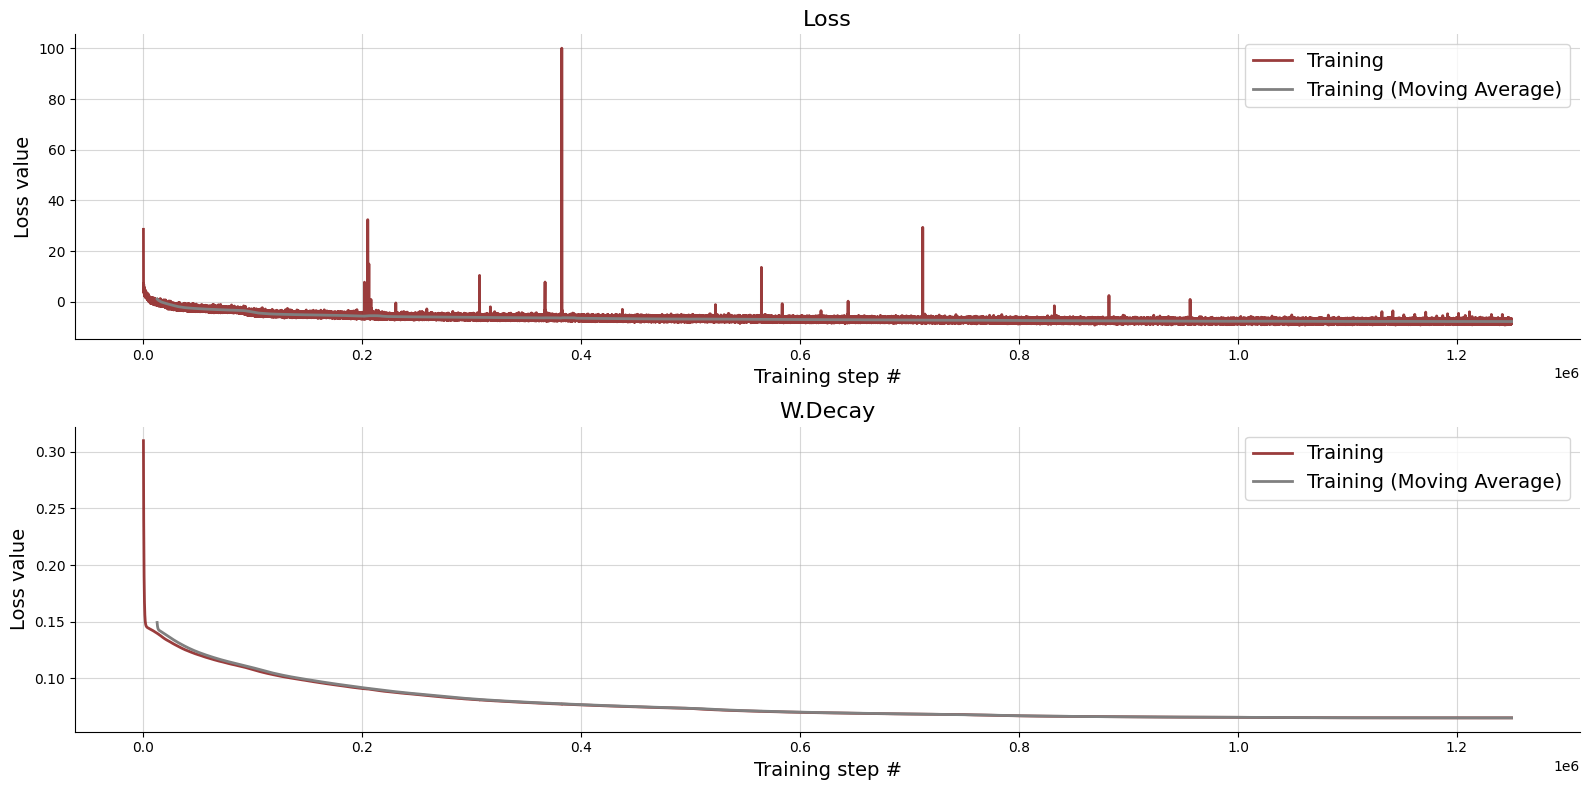

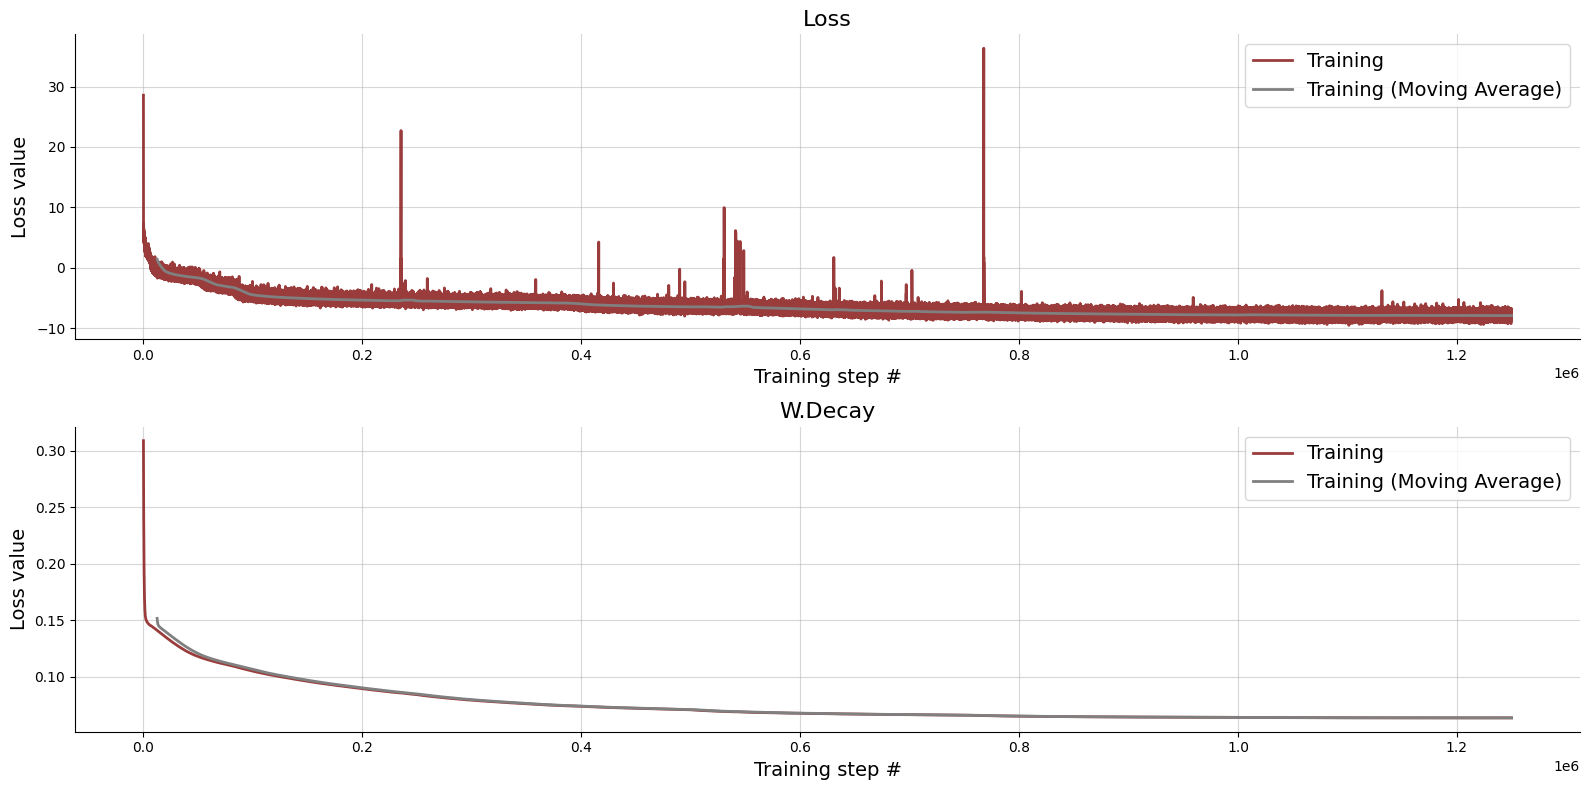

In [25]:
for network in range(NUM_ENSEMBLE_MEMBERS):
    amortizer, trainer, optimizer = setup_network(checkpoint_path=f"{my_checkpoint_path}/net{network + 1}")
    
    if not os.path.exists(f"{my_checkpoint_path}/net{network + 1}"):
        if TRAINING_MODE == "presimulation":
            if RUNNER == "pc1":
                losses = trainer.train_from_presimulation(FULL_PRESIM_PATH, 
                                                          optimizer = optimizer, 
                                                          reuse_optimizer=True
                                                         )
            else: 
                losses = trainer.train_from_presimulation(FULL_PRESIM_PATH, 
                                                          optimizer = optimizer, 
                                                          reuse_optimizer=True, 
                                                          custom_loader=multipickle_loader
                                                         )
        else:
            losses = trainer.train_online(epochs=NUM_EPOCHS, iterations_per_epoch=NUM_ITERATIONS_PER_EPOCH, batch_size=BATCH_SIZE)

    f = bf.diagnostics.plot_losses(trainer.loss_history.get_plottable(), moving_average=True)
    #f.savefig("{FIG_PATH}/" + MY_NAME + "_net" + str(network + 1) + "_losses.png")

# Validation

In [26]:
VAL_ROOT_PATH = "mvct/validation"
os.makedirs(VAL_ROOT_PATH, exist_ok=True)

VAL_SIMS_FILE = VAL_ROOT_PATH + "/val_sims_list_" + MY_NAME + ".pkl"
PRIOR_SAMPLES_FILE = VAL_ROOT_PATH + "/prior_samples_" + MY_NAME + ".pkl"
POST_SAMPLES_FILE = VAL_ROOT_PATH + "/post_samples_" + MY_NAME + ".pkl"

def save_data(data, file_path):
    with open(file_path, "wb") as f:
        pickle.dump(data, f)

def load_data(file_path):
    with open(file_path, "rb") as f:
        return pickle.load(f)

if all(os.path.exists(file) for file in [VAL_SIMS_FILE, PRIOR_SAMPLES_FILE, POST_SAMPLES_FILE]):
    print("Loading previously saved data...")
    val_sims_list = load_data(VAL_SIMS_FILE)
    prior_samples = load_data(PRIOR_SAMPLES_FILE)
    post_samples = load_data(POST_SAMPLES_FILE)
    print("Data loaded succesfully.")
else:
    print("Generating new data...")

    PRIOR_CONFIGS = {
        "levy": bf.simulation.Prior(batch_prior_fun=partial(prior_simulator_functions.levy_prior, fix_alpha=False), param_names=PARAM_NAMES),
        "ddm": bf.simulation.Prior(batch_prior_fun=partial(prior_simulator_functions.levy_prior, fix_alpha=True), param_names=PARAM_NAMES),
    }
    SIMULATOR_CONFIGS = {
        "no_deadline": bf.simulation.Simulator(batch_simulator_fun=partial(prior_simulator_functions.batch_simulator, deadline=False)),
        "deadline": bf.simulation.Simulator(batch_simulator_fun=partial(prior_simulator_functions.batch_simulator, deadline=True)),
    }

    val_sims_list = []

    def configure_and_append(prior_context, sim_context, num_sims=NUM_VAL_SIMS_PER_COMBINATION):
        prior = PRIOR_CONFIGS[prior_context]
        simulator = SIMULATOR_CONFIGS[sim_context]
        generative_model_combination = bf.simulation.GenerativeModel(prior=prior, simulator=simulator, skip_test=True)
        val_data_combination = generative_model_combination(batch_size=num_sims)
        val_data_combination['prior_non_batchable_context'] = 0 if prior_context == "levy" else 1
        val_data_combination['sim_non_batchable_context'] = 0 if sim_context == "no_deadline" else 1
        configured_val_data_combination = configurator(val_data_combination)
        val_sims_list.append(configured_val_data_combination)

    for prior_context, sim_context in itertools.product(PRIOR_CONTEXTS, SIMULATOR_CONTEXTS):
        configure_and_append(prior_context, sim_context)

    prior_samples = [val_data_combination["parameters"] for val_data_combination in val_sims_list]

    post_samples = []
    for network in range(NUM_ENSEMBLE_MEMBERS):
        amortizer, trainer, optimizer = setup_network(checkpoint_path=f"{my_checkpoint_path}/net{network + 1}")
        network_samples = [amortizer.sample(val_data_combination, n_samples=NUM_VAL_SAMPLES) for val_data_combination in val_sims_list]
        post_samples.append(network_samples)

    print("Saving data...")
    save_data(val_sims_list, VAL_SIMS_FILE)
    save_data(prior_samples, PRIOR_SAMPLES_FILE)
    save_data(post_samples, POST_SAMPLES_FILE)
    print("Data saved successfully.")

Loading previously saved data...
Data loaded succesfully.


In [27]:
def filter_nan_post_samples(post_samples, prior_samples, num_combinations, num_ensemble_members):
    post_samples_filtered = copy.deepcopy(post_samples)

    for c in range(num_combinations):
        for network in range(num_ensemble_members):
            nan_mask = np.isnan(post_samples_filtered[network][c])
            
            if np.any(nan_mask):
                nan_fraction = nan_mask.sum() / post_samples_filtered[network][c].size
                num_parameters = post_samples_filtered[network][c].shape[-1]
                print(f"Number of NaN samples in network {network + 1}, condition {c + 1}: {nan_mask.sum() / num_parameters}")
                print(f"Fraction of NaNs in network {network + 1}, condition {c + 1}: {nan_fraction}")
                
                nan_dataset_indices = np.any(nan_mask, axis=1)
                nan_sample_indices = np.any(nan_mask, axis=(0, 2))
                print(f"NaN in posterior samples for following prior samples: {prior_samples[c][nan_dataset_indices]}")
                post_samples_filtered[network][c] = post_samples_filtered[network][c][:, ~nan_sample_indices, :]

    return post_samples_filtered

post_samples_filtered = filter_nan_post_samples(
    post_samples=post_samples,
    prior_samples=prior_samples,
    num_combinations=NUM_COMBINATIONS,
    num_ensemble_members=NUM_ENSEMBLE_MEMBERS
)

Network 1


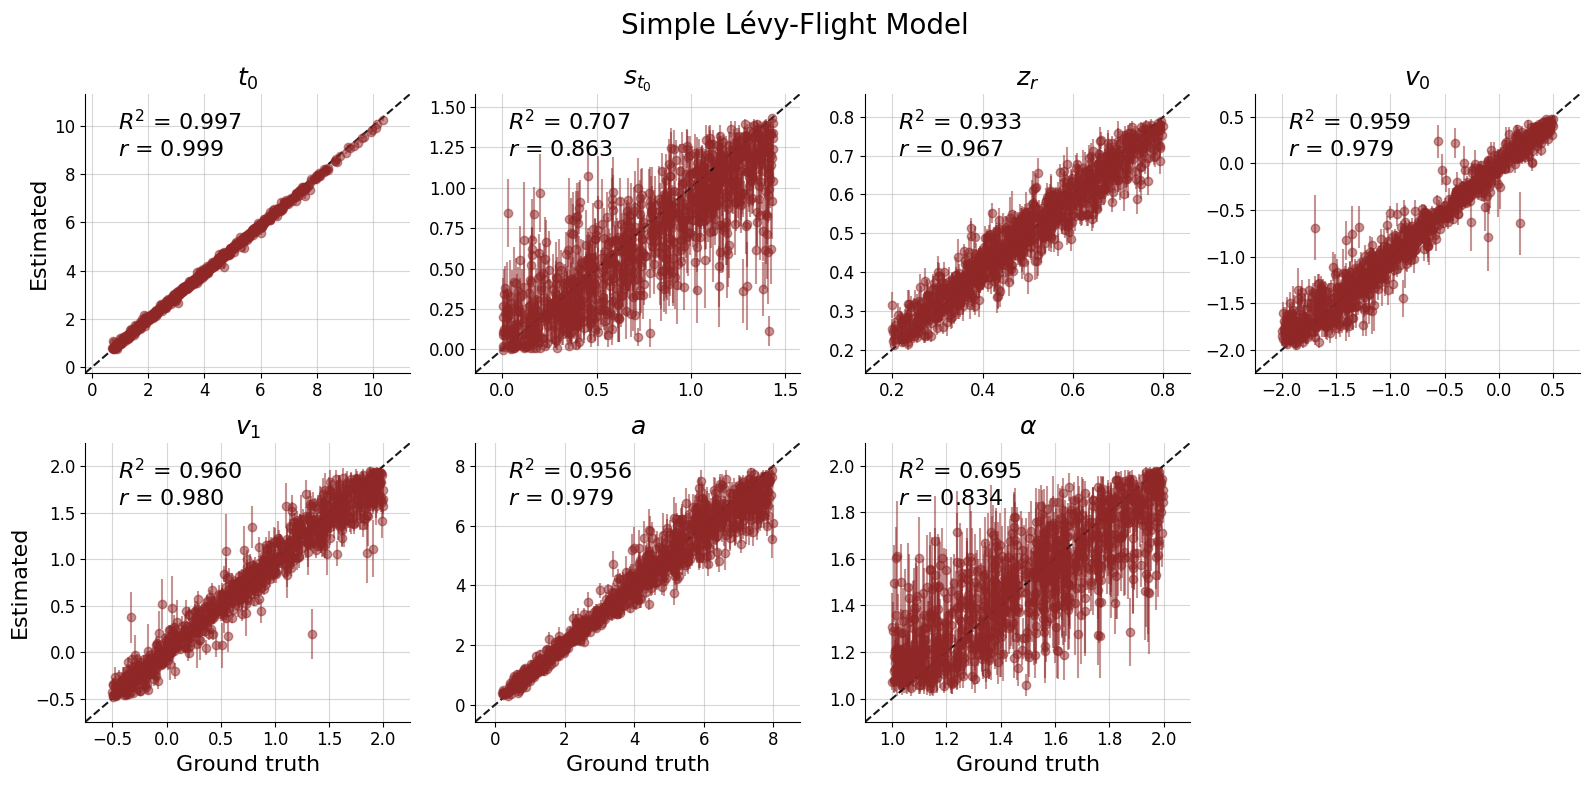

Network 2


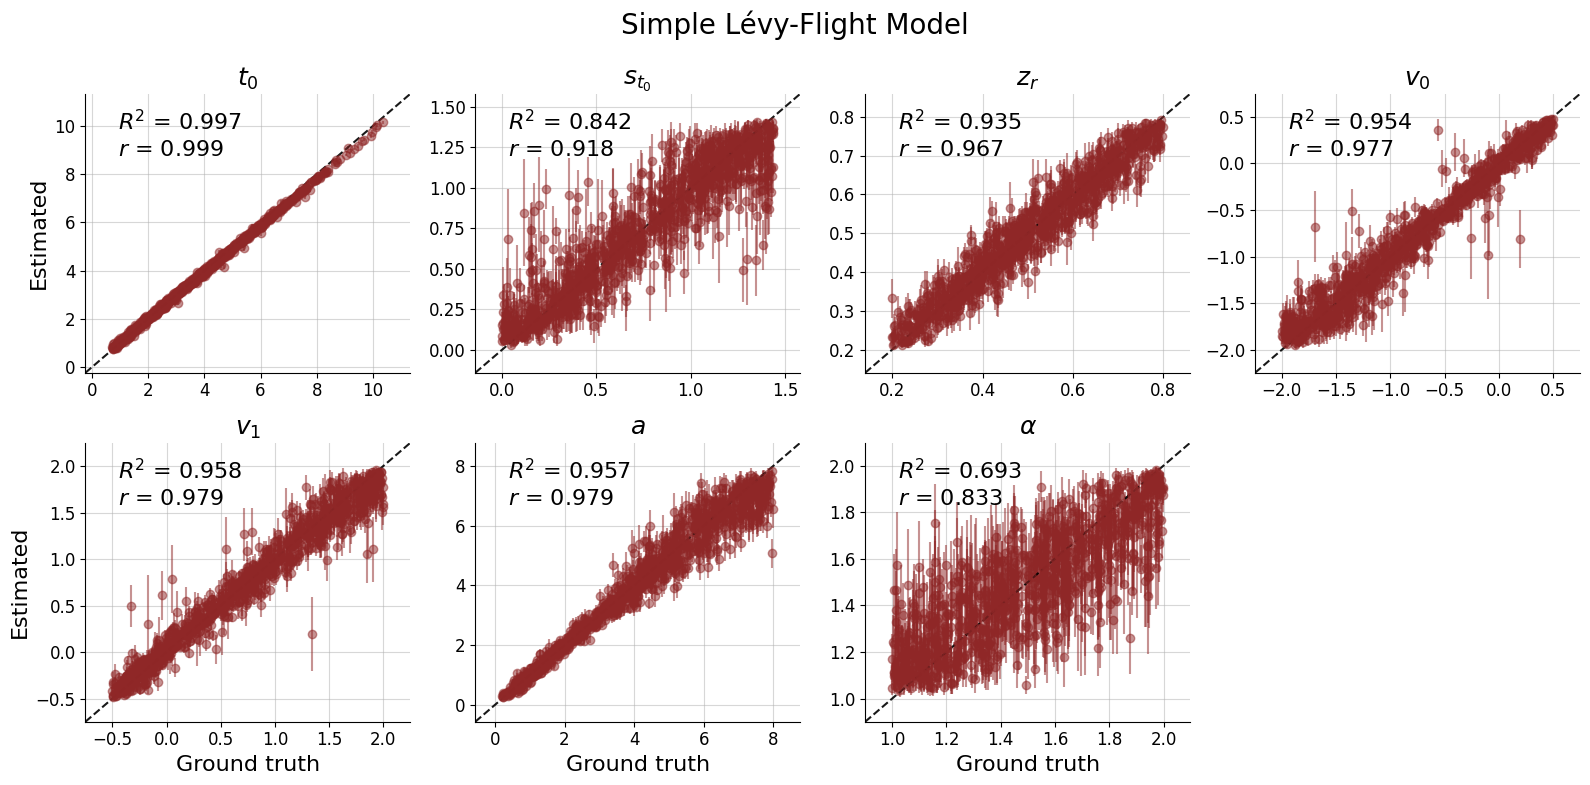

In [28]:
# Median posterior recovery
for c in range(NUM_COMBINATIONS):
    for network in range(NUM_ENSEMBLE_MEMBERS):
        comp_model = "ddm" if val_sims_list[c]["direct_conditions"][0, 1] else "levy"
        condition = "deadline" if val_sims_list[c]["direct_conditions"][0, 2] else "no_deadline"

        if comp_model == "ddm":
            post_samples_mod = post_samples_filtered[network][c]
            post_samples_mod = post_samples_mod[..., :-1]  
            prior_samples_mod = prior_samples[c][..., :-1]        
            param_names = PARAM_LABELS[:6] 
        else:
            post_samples_mod = post_samples[network][c]
            prior_samples_mod = prior_samples[c]
            param_names = PARAM_LABELS
        
        f = bf.diagnostics.plot_recovery(post_samples_mod, prior_samples_mod, param_names=param_names,
                                        n_row=2, n_col=4)
        
        f.suptitle(f'Simple {model_map.get(comp_model)} Model', fontsize=20, y=0.975)
        #annotation = "A" if comp_model == "levy" else "B"
        #f.text(0.01, 0.95, annotation, fontsize=20, ha='left', fontweight='bold')
        plt.tight_layout(rect=[0, 0, 1, 0.98])

        filename = f"{FIG_PATH}/figB4_recovery_net{network+1}_{comp_model}.png"
        plt.savefig(filename, transparent=False, bbox_inches='tight', dpi=MY_DPI)

        print(f'Network {network + 1}')
        plt.show()

Network 1


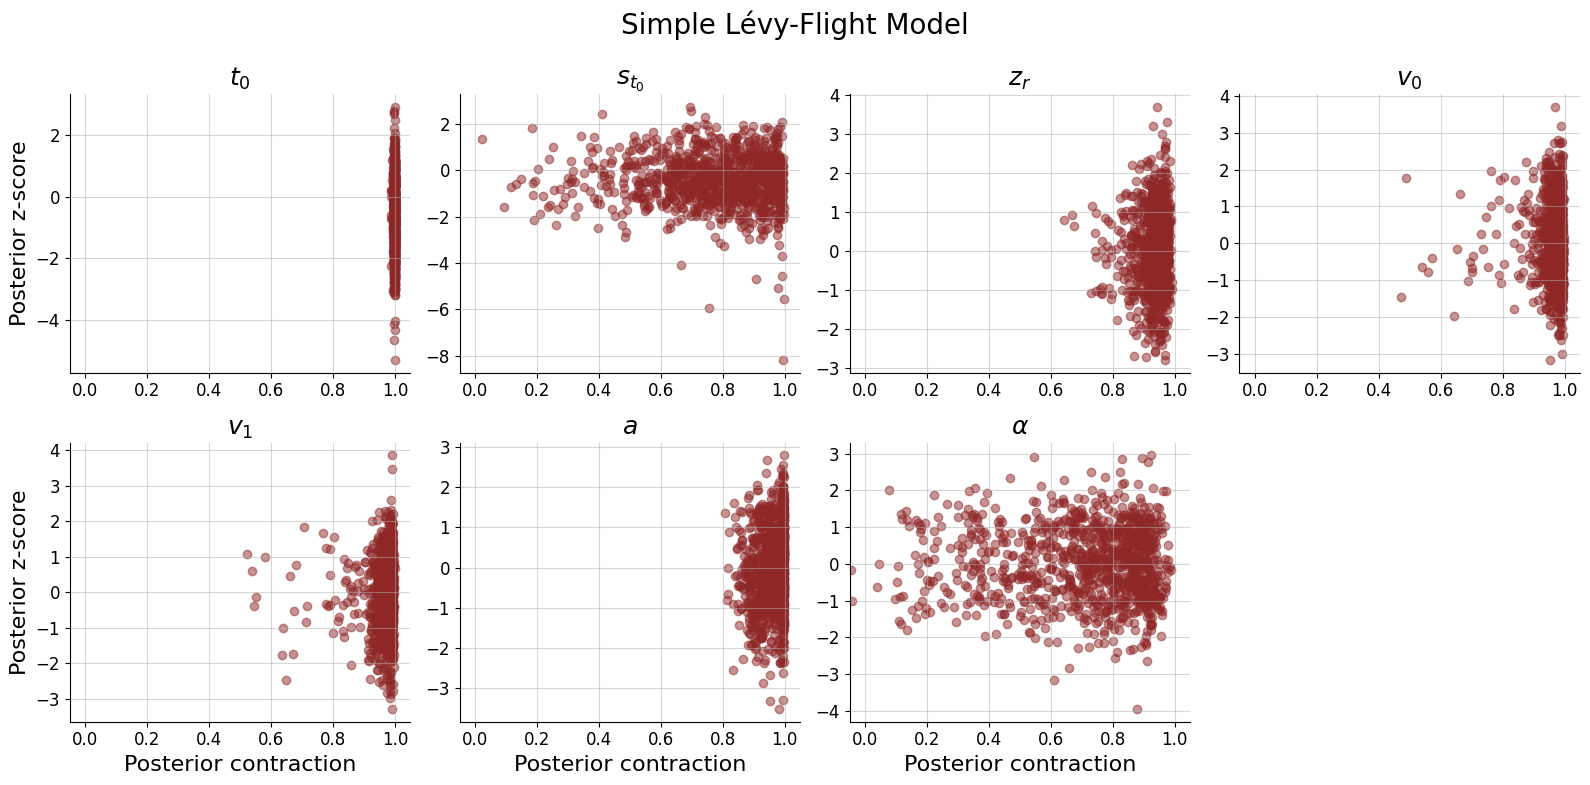

Network 2


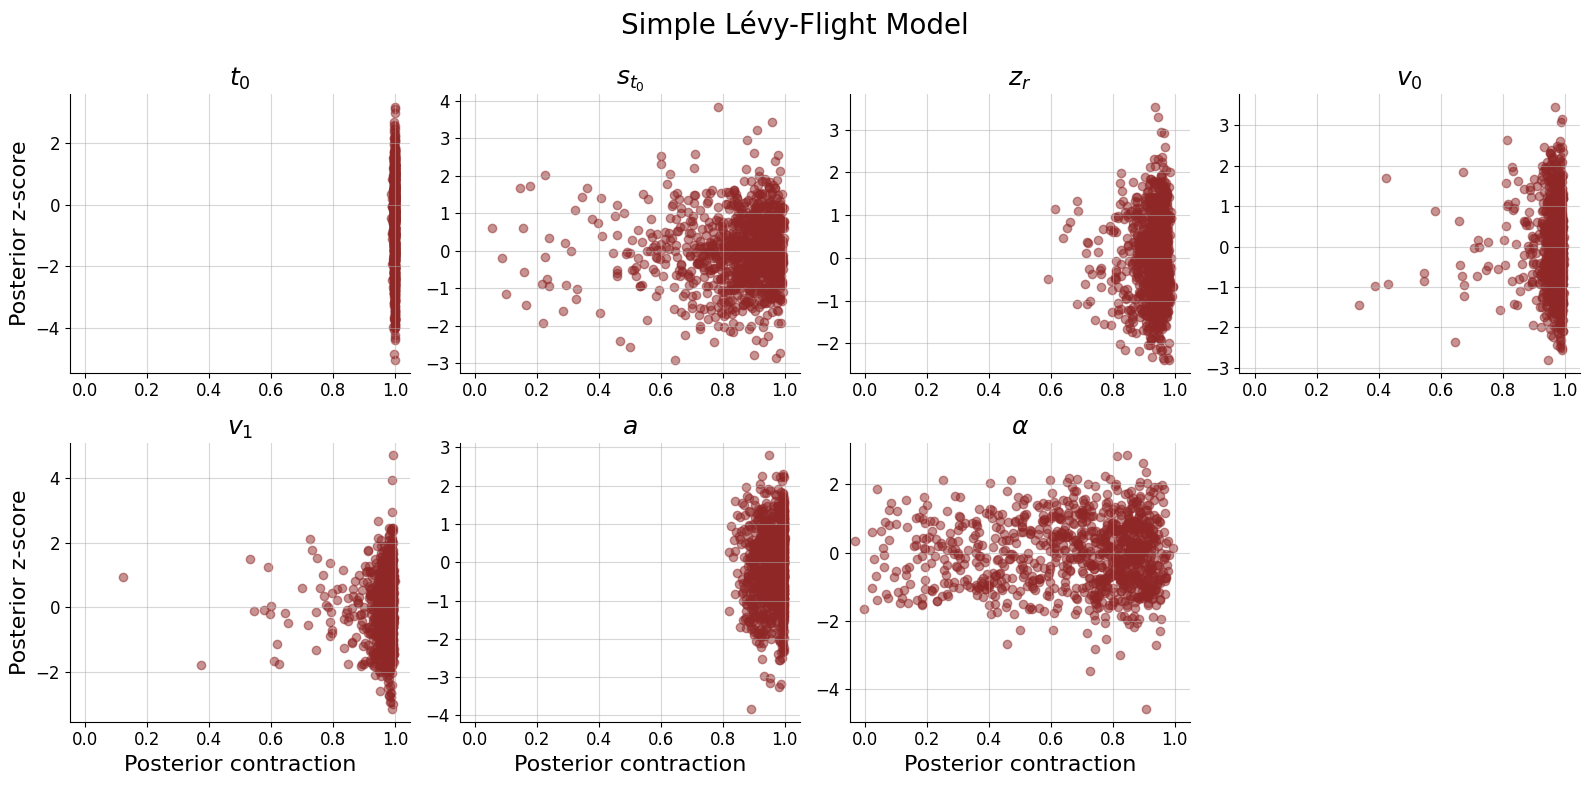

In [29]:
# Posterior contraction
for c in range(NUM_COMBINATIONS):
    for network in range(NUM_ENSEMBLE_MEMBERS):
        comp_model = "ddm" if val_sims_list[c]["direct_conditions"][0, 1] else "levy"
        condition = "deadline" if val_sims_list[c]["direct_conditions"][0, 2] else "no deadline"
        f = bf.diagnostics.plot_z_score_contraction(post_samples[network][c], prior_samples[c], param_names=PARAM_LABELS)

        f.suptitle(f'Simple {model_map.get(comp_model)} Model', fontsize=20, y=0.975)
        #annotation = "A" if comp_model == "levy" else "B"
        #f.text(0.01, 0.95, annotation, fontsize=20, ha='left', fontweight='bold')
        plt.tight_layout(rect=[0, 0, 1, 0.98])

        filename = f"{FIG_PATH}/figB5_contraction_net{network+1}_{comp_model}.png"
        plt.savefig(filename, transparent=False, bbox_inches='tight')

        print(f'Network {network + 1}')
        plt.show()

levy; network 1


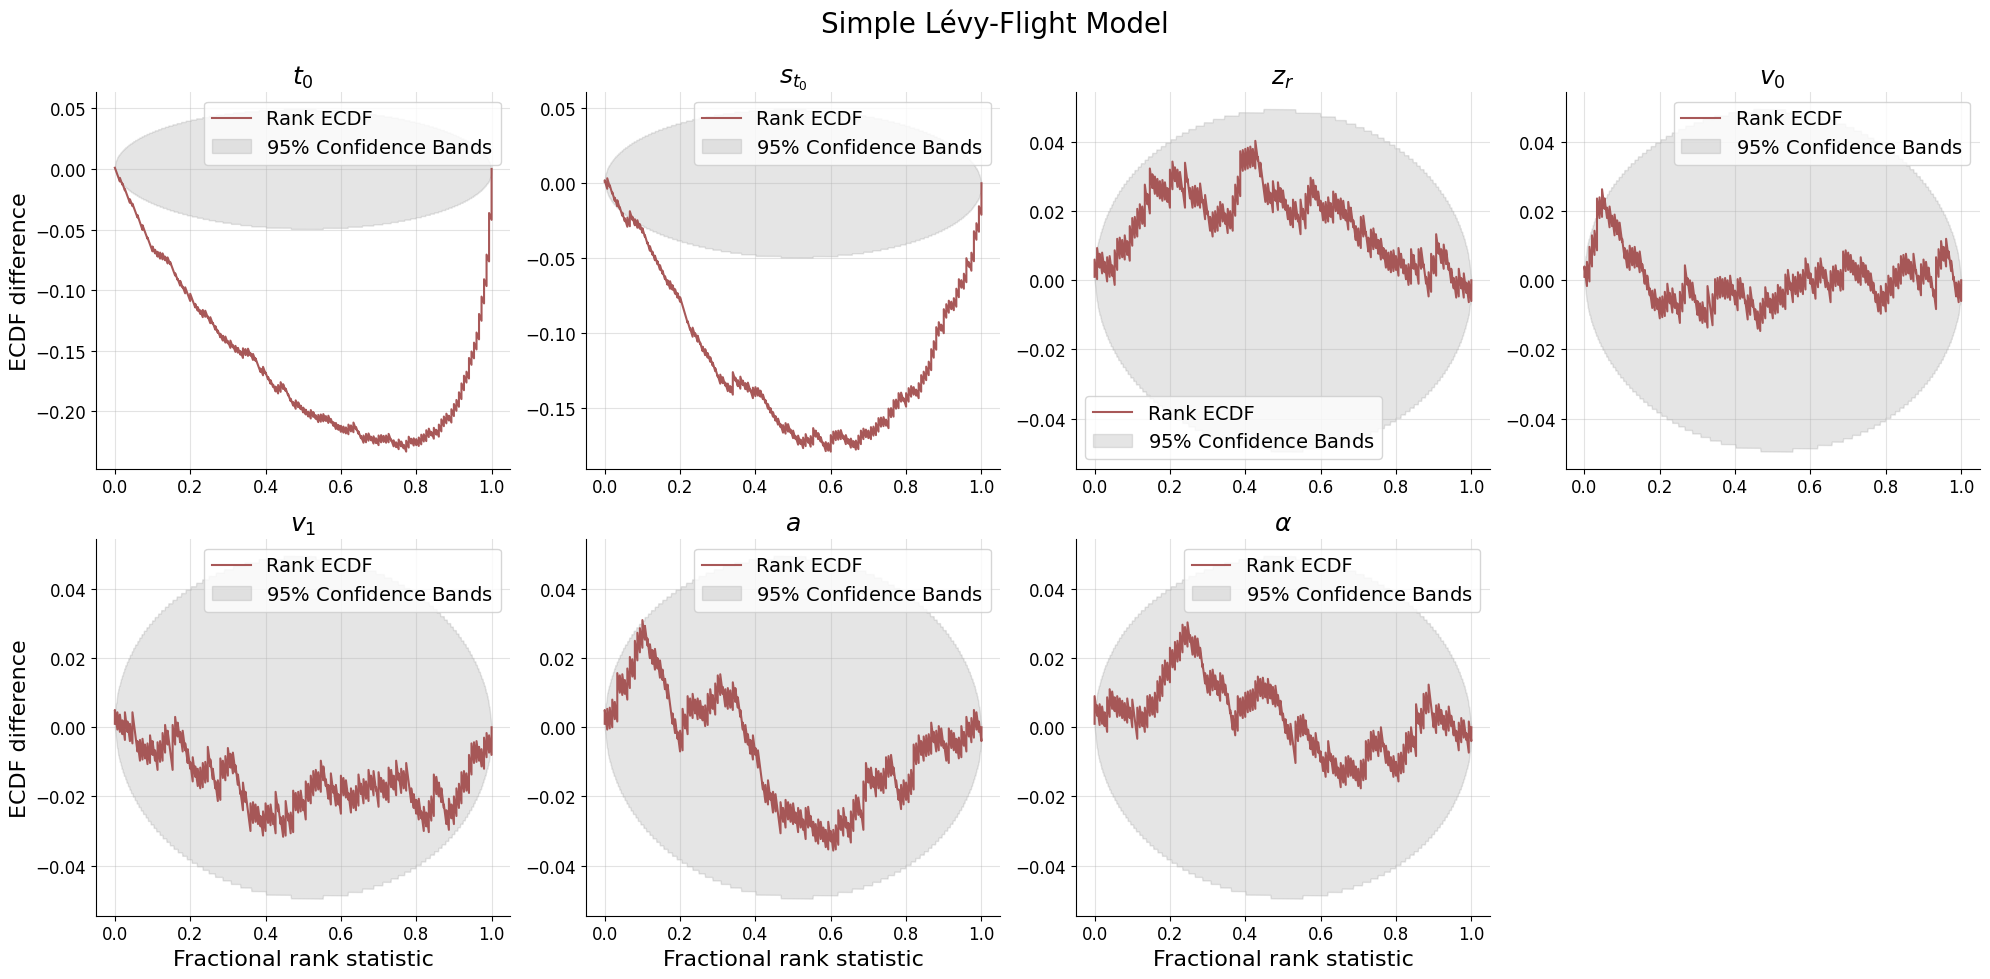

levy; network 2


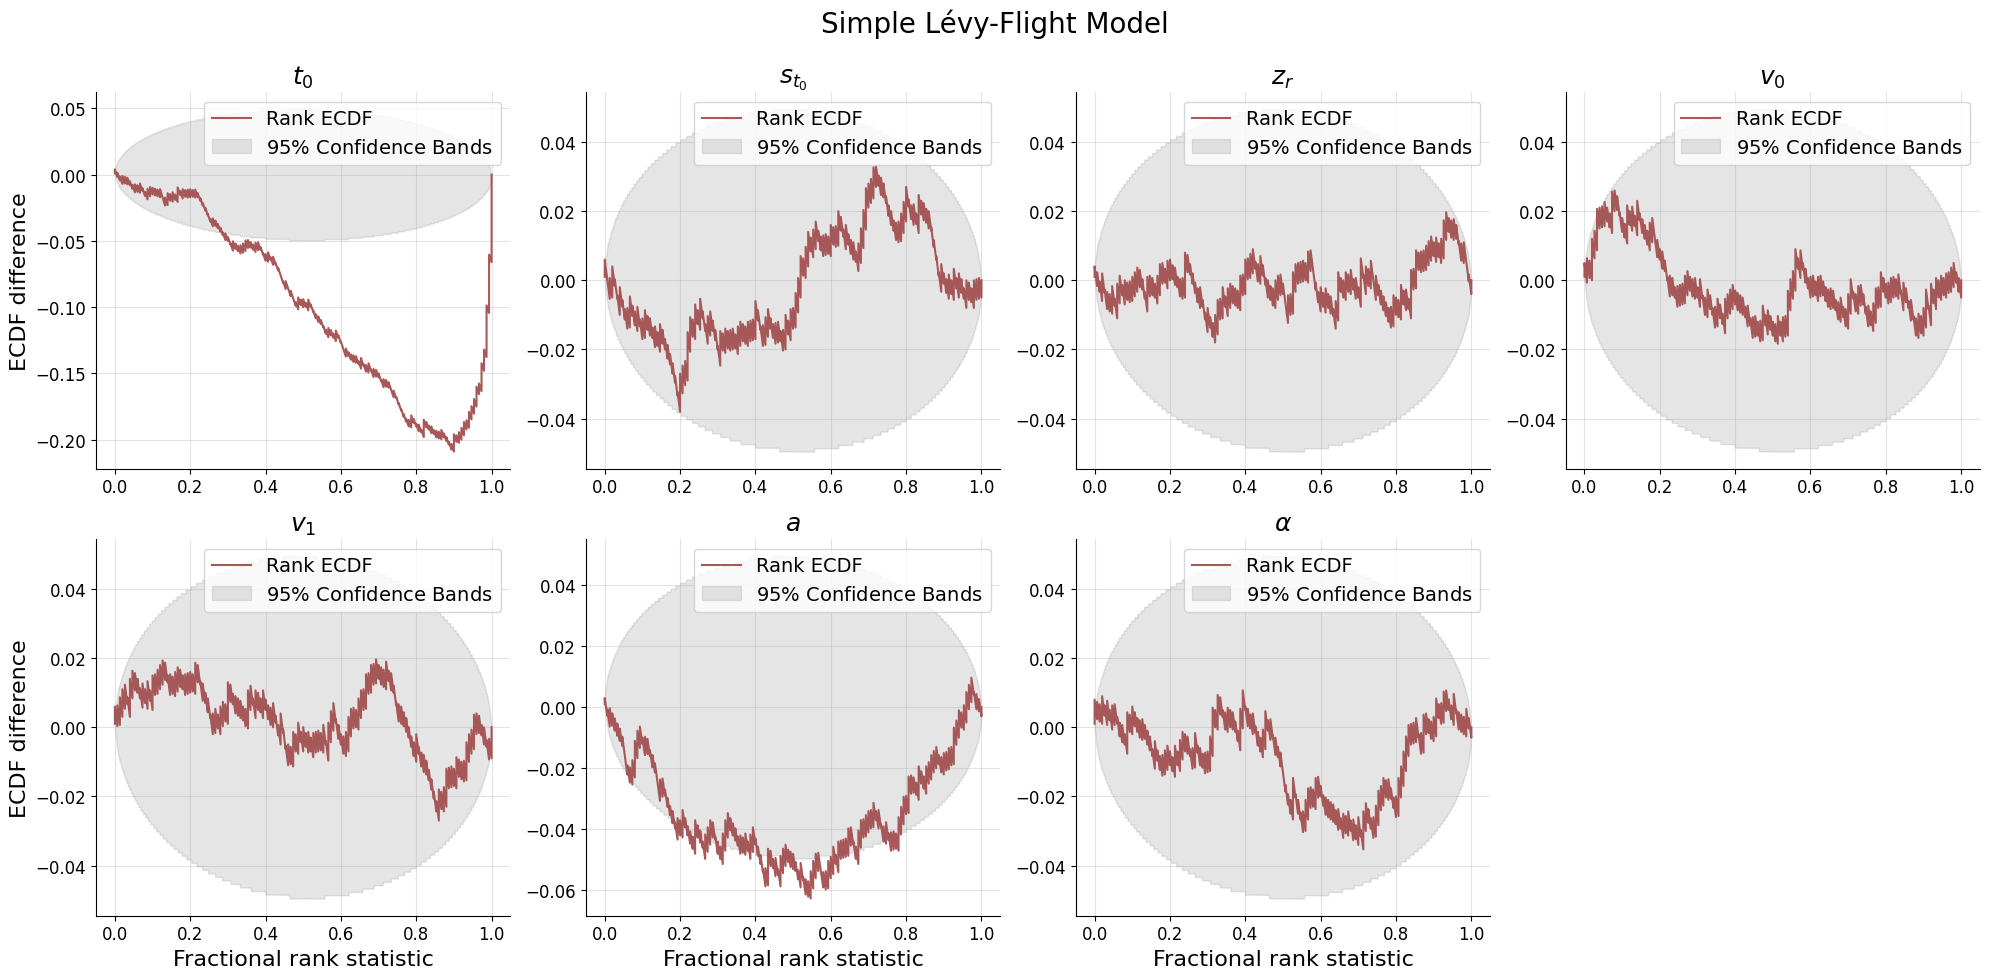

In [30]:
# SBC ECDFs
for c in range(NUM_COMBINATIONS):
    for network in range(NUM_ENSEMBLE_MEMBERS):
        comp_model = "ddm" if val_sims_list[c]["direct_conditions"][0, 1] else "levy"
        condition = "deadline" if val_sims_list[c]["direct_conditions"][0, 2] else "no_deadline"
        
        if comp_model == "ddm" and must_edit==0:
            post_samples_mod = post_samples[network][c][..., :-1]  
            prior_samples_mod = prior_samples[c][..., :-1]        
            param_names = PARAM_LABELS[:6]  
        else:
            post_samples_mod = post_samples[network][c]
            prior_samples_mod = prior_samples[c]
            param_names = PARAM_LABELS
            
        f = bf.diagnostics.plot_sbc_ecdf(
            post_samples_mod, prior_samples_mod,
            stacked=False, difference=True, param_names=param_names,
            n_row=2, n_col=4 
        )
        
        f.suptitle(f'Simple {model_map.get(comp_model)} Model', fontsize=20, y=0.975)
        #annotation = "A" if comp_model == "levy" else "B"
        #f.text(0.01, 0.95, annotation, fontsize=20, ha='left', fontweight='bold')
        plt.tight_layout(rect=[0, 0, 1, 0.98])

        filename = f"{FIG_PATH}/figB6_ecdf_net{network+1}_{comp_model}.png"
        plt.savefig(filename, transparent=False, bbox_inches='tight', dpi=MY_DPI)

        print(f'{comp_model}; network {network + 1}')
        plt.show()

# Settings

In [31]:
# Set paths
DATA_ROOT_PATH = "mvct/behav_demo_data/prepared2/"
ESTIM_ROOT_PATH = f"mvct/estimates_param_estim_means/" 
SIM_ROOT_PATH = f"mvct/simulates_param_estim_means/"

os.makedirs(ESTIM_ROOT_PATH, exist_ok=True)
os.makedirs(SIM_ROOT_PATH, exist_ok=True)

In [32]:
# Set constants
conditions = ['control', 'guess']
condition_order = ["control", "guess"]
condition_labels = ["Control", "Guessing"]
condition_map = {"control": "Control Group", "guess": "Guessing Group"}

simulator_title = "Context"
simulator_labels = ["Absent"]
model_map_title_case = {'levy': 'Lévy-Flight', 'ddm': 'Diffusion'} 

p="no_deadline"

NUM_STUDIES = 2
tukey = 1.5

In [33]:
# Color function
def blend_with_white(color, alpha=0.5):
    original_color = mcolors.to_rgb(color)
    white = (1, 1, 1) 
    blended_color = [alpha * oc + (1 - alpha) * w for oc, w in zip(original_color, white)]
    return mcolors.to_hex(blended_color)
base_palette = {"control": "#515151", "guess": "#C4C4C4"}
alpha_value = 0.6 
palette = {key: blend_with_white(color, alpha=alpha_value) for key, color in base_palette.items()}

In [34]:
# Tick function
def apa_tick_formatter(digits=1):
    def formatter(x, _):
        if x == int(x):
            if x >= 0:
                return str(int(x))
            else:
                return '−' + str(int(abs(x)))
        else:
            formatted = f'{abs(x):.{digits}f}'  
            trimmed = formatted.lstrip('0')
            if x < 0:
                return '−' + trimmed
            else:
                return trimmed
    return formatter

In [35]:
# Functions to load and prepare data
def load_data(directory):
    data = []
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            participant_data = pd.read_csv(os.path.join(directory, filename))
            participant_data['file'] = filename
            data.append(participant_data)
    return pd.concat(data, ignore_index=True)

def prepare_data(data_type="empirical", calculate_by_symbol=True, return_type="summary", 
                 network=0, p="levy", s="no_context", study=0, tukey=1.5, half=False,
                 emp_path = DATA_ROOT_PATH):
    if data_type == "empirical":
        
        DATA_PATH = emp_path + f"study{study+1}_tukey{tukey}/"
        all_data = load_data(directory=DATA_PATH)
        pattern = r'pp(?P<pp>\d+)_(?P<cond>guess|control)_ans(?P<ans>\d+)_att(?P<att>\d+)_acc(?P<acc>\d+)\.csv$'
        extracted = all_data['file'].str.extract(pattern)
        extracted = extracted.astype({'pp': int, 'ans': int, 'att': int, 'acc': int})
        all_data = pd.concat([all_data, extracted], axis=1)
        all_data['symbol'] = all_data['mean']
        all_data.drop(columns=['file'], inplace=True)
    
    elif data_type == "simulated":
        my_path = f"{MY_NAME}_study{study+1}_tukey{tukey}_net{network+1}.csv"
        simulates_path = SIM_ROOT_PATH + my_path
        all_data = pd.read_csv(simulates_path)
        all_data['RT'] = all_data['rt']
        all_data['symbol'] = all_data['symbol'].astype(int)
        all_data = all_data.drop(columns=['rt'])

    all_data['correct'] = np.nan #{450: 0, 550: 1}
    condition1 = (all_data['RT'] < 0) & (all_data['symbol'] == 1)
    condition2 = (all_data['RT'] > 0) & (all_data['symbol'] == 1)
    condition3 = (all_data['RT'] < 0) & (all_data['symbol'] == 0)
    condition4 = (all_data['RT'] > 0) & (all_data['symbol'] == 0)
    all_data.loc[condition1, 'correct'] = 0
    all_data.loc[condition2, 'correct'] = 1
    all_data.loc[condition3, 'correct'] = 1
    all_data.loc[condition4, 'correct'] = 0

    all_data.loc[all_data['RT'] == 0, 'RT'] = np.nan
    all_data['RT_log'] = np.log(abs(all_data['RT']))
    all_data['RT'] = abs(all_data['RT']) 

    all_data['study']= study+1

    if data_type == "simulated":
        all_data['origin'] = s
        all_data['model'] = p
    else:
        all_data['origin'] = "empirical"
        all_data['model'] = "none"
        
    if return_type == "raw":
        return all_data
    
    if calculate_by_symbol:
        group_cols = ['pp', 'symbol', 'cond']
    else:
        group_cols = ['pp', 'cond']

    if half and data_type == "empirical":
        group_cols.append('half')

    accuracy_data = all_data.groupby(group_cols)['correct'].mean().reset_index(name='accuracy')
    meanRT_correct = all_data[all_data['correct'] == 1].groupby(group_cols)['RT'].mean().reset_index(name='meanRT_correct')
    meanRT_incorrect = all_data[all_data['correct'] == 0].groupby(group_cols)['RT'].mean().reset_index(name='meanRT_incorrect')
    meanRTlog_correct = all_data[all_data['correct'] == 1].groupby(group_cols)['RT_log'].mean().reset_index(name='meanRTlog_correct')
    meanRTlog_incorrect = all_data[all_data['correct'] == 0].groupby(group_cols)['RT_log'].mean().reset_index(name='meanRTlog_incorrect')
    quantiles_correct = all_data[all_data['correct'] == 1].groupby(group_cols)['RT'].quantile([0.1, 0.25, 0.3, 0.5, 0.7, 0.75, 0.9]).unstack()
    quantiles_incorrect = all_data[all_data['correct'] == 0].groupby(group_cols)['RT'].quantile([0.1, 0.25, 0.3, 0.5, 0.7, 0.75, 0.9]).unstack()
    stats_correct = all_data[all_data['correct'] == 1].groupby(group_cols)['RT'].agg(['skew', 'std']).reset_index()
    stats_correct = stats_correct.rename(columns={'skew': 'skew_correct', 'std': 'stdRT_correct'})
    stats_incorrect = all_data[all_data['correct'] == 0].groupby(group_cols)['RT'].agg(['skew', 'std']).reset_index()
    stats_incorrect = stats_incorrect.rename(columns={'skew': 'skew_incorrect', 'std': 'stdRT_incorrect'})
    ntrials_data = all_data.groupby(group_cols)['RT'].count().reset_index(name='n_trials')

    result_data = accuracy_data.merge(meanRT_correct, on=group_cols, how='left')
    result_data = result_data.merge(meanRT_incorrect, on=group_cols, how='left')
    result_data = result_data.merge(meanRTlog_correct, on=group_cols, how='left')
    result_data = result_data.merge(meanRTlog_incorrect, on=group_cols, how='left')
    result_data = result_data.merge(quantiles_correct, on=group_cols, how='left')
    result_data = result_data.merge(quantiles_incorrect, on=group_cols, how='left', suffixes=('_correct', '_incorrect'))
    result_data = result_data.merge(stats_correct, on=group_cols, how='left')
    result_data = result_data.merge(stats_incorrect, on=group_cols, how='left')
    result_data = result_data.merge(ntrials_data, on=group_cols, how='left')

    result_data['fast_errors'] = (result_data['meanRT_incorrect'] < result_data['meanRT_correct']).astype(int)
   
    if data_type == "simulated":
        result_data['origin'] = s
        result_data['model'] = p
    else:
        result_data['origin'] = "empirical"
        result_data['model'] = "none"

    result_data['study']=study+1

    return result_data

# Behavioral Variables

In [36]:
behavioral_params = ['accuracy', 'meanRT_correct']
fancy_labels = ["Accuracy Rate", "Mean Response Time (s)"]
my_marker_size = 15
palette_temp = {f'symbol{i}{cond}': palette[cond] for i in range(2) for cond in ['control', 'guess']}
y_lims = {'accuracy': [0, 1], 'meanRT_correct': [0, 20]}

In [37]:
df_list = []

for study in range(NUM_STUDIES):
    df_study = prepare_data(
        data_type="empirical",
        calculate_by_symbol=True,
        return_type="summary",
        study=study,
        half=False)
    df_study["study"] = f"study{study + 1}" 
    df_study["study_symbol"] = df_study["study"] + "_symbol" + df_study["symbol"].astype(str)
    df_study["symbol_cond"] = "symbol" + df_study["symbol"].astype(str) + df_study["cond"]
    df_list.append(df_study)

df = pd.concat(df_list, ignore_index=True)
order = [f"study{i+1}" for i in range(NUM_STUDIES)]
hue_order = ["symbol0guess", "symbol1guess", "symbol0control", "symbol1control"]

df["symbol_cond"] = pd.Categorical(df["symbol_cond"], categories=hue_order, ordered=True)

df["study"] = pd.Categorical(df["study"], categories=order, ordered=True)

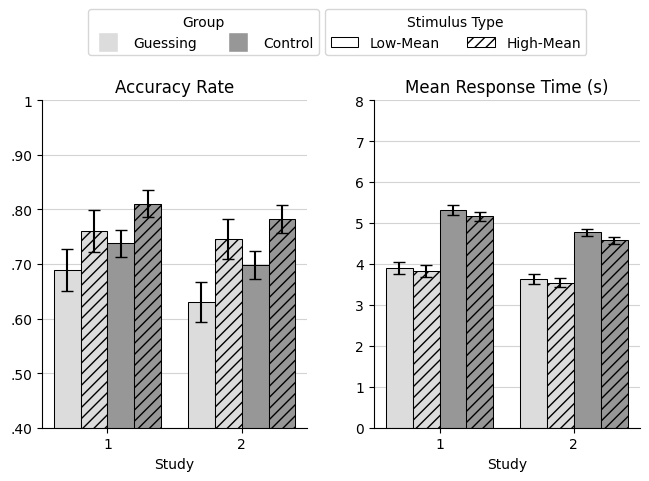

In [38]:
boxes_to_hatch = {2, 3, 6, 7} 

y_lims = {'accuracy': [.4, 1], 'meanRT_correct': [0, 8], 'meanRT_incorrect': [0, 8]}

tmp = df['symbol_cond'].str.extract(r'^(symbol\d)(control|guess)$')
df['symbol'] = pd.Categorical(tmp[0], categories=sorted(tmp[0].dropna().unique()), ordered=True)

study_order = sorted(df['study'].unique().tolist())
hue_order   = list(palette_temp.keys())  

df['study'] = pd.Categorical(df['study'], categories=study_order, ordered=True)

def mixed_within_ci(data, dv, subject='pp', within='symbol', between='cond', by=('study',)):
    out_list = []
    for keys, g in data.groupby(list(by) + [between], sort=False, observed=True):
        k = int(g[within].nunique())
        k = max(k, 1)

        grand_mean = g[dv].mean()
        g_norm = g.copy()
        subj_means = g_norm.groupby(subject, observed=True)[dv].transform('mean')
        g_norm[dv + '_norm'] = g_norm[dv] - subj_means + grand_mean

        cell = (
            g_norm.groupby(list(by) + [between, within], observed=True)[dv + '_norm']
                 .agg(['mean', 'std', 'count'])
                 .reset_index()
        )
        cm = np.sqrt(k / (k - 1)) if k > 1 else 1.0
        cell['se'] = cell['std'] / np.sqrt(cell['count'].clip(lower=1))
        cell['tcrit'] = cell['count'].apply(lambda n: stats.t.ppf(0.975, df=max(n - 1, 1)))
        cell['ci95'] = cell['tcrit'] * cell['se'] * cm

        out_list.append(cell)

    out = pd.concat(out_list, ignore_index=True) if out_list else pd.DataFrame(columns=list(by)+[between, within, 'mean','ci95'])
    out = out.rename(columns={'mean': 'mean_' + dv, 'ci95': 'ci95_' + dv})

    out['symbol_cond'] = out[within].astype(str) + out[between].astype(str)
    keep_cols = list(by) + [between, within, 'symbol_cond', 'mean_' + dv, 'ci95_' + dv]
    return out[keep_cols]

if len(behavioral_params) > 3:
    fig = plt.figure(figsize=(8, 12))
    gs = gridspec.GridSpec(3, 2, figure=fig, wspace=0.25, hspace=0.35)
else:
    fig = plt.figure(figsize=(12, 10))
    gs = gridspec.GridSpec(2, 3, figure=fig, wspace=0.25, hspace=0.35)

for i, (param, label) in enumerate(zip(behavioral_params, fancy_labels)):
    ax = fig.add_subplot(gs[i])
    if param in y_lims:
        ax.set_ylim(y_lims[param])

    summ = mixed_within_ci(df, dv=param, subject='pp',
                           within='symbol', between='cond', by=('study',))
    summ = summ.rename(columns={f'mean_{param}': 'mean', f'ci95_{param}': 'ci95'})

    sns.barplot(
        x='study', y=param, data=df, hue="symbol_cond", capsize = 0.25,  err_kws={'linewidth': 1.5},
        palette=palette_temp, ax=ax, zorder=2,
        linewidth=0.75, edgecolor="black", errorbar=None  
    )

    bars = [p for p in ax.patches if hasattr(p, 'get_height') and p.get_height() != 0]

    idx = pd.MultiIndex.from_product([study_order, hue_order], names=['study','symbol_cond'])
    summ_idx = (summ.set_index(['study','symbol_cond'])
                     .reindex(idx)
                     .reset_index()
                     .dropna(subset=['mean']))

    if len(bars) != len(summ_idx):
        bars = bars[:len(summ_idx)]

    for bar, (_, row) in zip(bars, summ_idx.iterrows()):
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()
        ax.errorbar(x, y, yerr=row['ci95'], fmt='none',
                    ecolor='black', elinewidth=1.5, capsize=4, zorder=3)

    for idx_b, bar in enumerate(bars):
        bar.set_hatch('///' if idx_b in boxes_to_hatch else '')
        bar.set_edgecolor('black')
        bar.set_linewidth(0.75)

    new_labels = [tick.get_text().replace("study", "") for tick in ax.get_xticklabels()]
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(new_labels)
    
    ax.set_title(label)
    ax.set_xlabel('Study')
    ax.set_ylabel('')
    ax.grid(True, which="major", axis='y', color='lightgrey', zorder=0)
    if param == "accuracy":
        ax.yaxis.set_major_formatter(FuncFormatter(apa_tick_formatter(digits=2)))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if ax.get_legend():
        ax.get_legend().remove()

legend1 = fig.legend(
    handles=[
        mpatches.Patch(facecolor='white', edgecolor='black', label="Low-Mean", hatch='', lw=0.75),
        mpatches.Patch(facecolor='white', edgecolor='black', label="High-Mean", hatch='///', lw=0.75)
    ],
    loc='upper center', bbox_to_anchor=(0.47, 0.978), ncol=2,
    title='Stimulus Type', fontsize=10, frameon=True
)
plt.setp(legend1.get_title(), fontsize=10)

legend2 = fig.legend(
    handles=[
        mlines.Line2D([0], [0], marker='s', color='w', label="Guessing",
                      markerfacecolor=palette['guess'], markersize=my_marker_size),
        mlines.Line2D([0], [0], marker='s', color='w', label="Control",
                      markerfacecolor=palette['control'], markersize=my_marker_size)
    ],
    loc='upper center', bbox_to_anchor=(0.26, 0.978), ncol=2,
    title='Group', fontsize=10, frameon=True
)
plt.setp(legend2.get_title(), fontsize=10)
plt.savefig(f"{FIG_PATH}/fig2_behav.png", dpi=MY_DPI, bbox_inches="tight")

plt.show()

In [39]:
df_list = []

for study in range(NUM_STUDIES):
    df_study = prepare_data(
        data_type="empirical",
        calculate_by_symbol=True,
        return_type="summary",
        study=study,
        half=False)
    df_study["study"] = study + 1
    df_list.append(df_study)

df = pd.concat(df_list, ignore_index=True)

file_path = "mvct/behav_demo_data/result_empirical.csv"
if not os.path.isfile(file_path):
    df.to_csv(file_path, index=False)
    print(f"File created: {file_path}")
else:
    print(f"File already exists: {file_path}")

File already exists: mvct/behav_demo_data/result_empirical.csv


# Estimate Parameters

In [40]:
for network in range(NUM_ENSEMBLE_MEMBERS):
    for p in PRIOR_CONTEXTS:
        amortizer, trainer, optimizer = setup_network(checkpoint_path=f"{my_checkpoint_path}/net{network+1}")

        for study in range(NUM_STUDIES):
            DATA_PATH = DATA_ROOT_PATH + f"study{study+1}_tukey{tukey}/"
            my_path = f"{MY_NAME}_study{study+1}_tukey{tukey}_net{network+1}.csv"
            estimates_path = ESTIM_ROOT_PATH + my_path

            if not os.path.exists(estimates_path):
                print("generating data for study", study+1)
                datafiles = glob.glob(DATA_PATH + '*.csv')
                estimates = []
                
                for datafile in datafiles:
                    raw_data = pd.read_csv(datafile)
                    data = np.expand_dims(raw_data.to_numpy(), 0)
                    data = np.delete(data, 2, axis=2)  # Delete half column

                    num_obs = int(np.sqrt(data.shape[1]))
                    prior_context = 0 if p == "levy" else 1
                    sim_context = 0
                    direct_conditions = np.array([num_obs, prior_context, sim_context])[np.newaxis, ...]

                    thisdict = {"summary_conditions": data, "direct_conditions": direct_conditions}

                    samples = amortizer.sample(thisdict, n_samples=5000, to_numpy=True)

                    if "means" in ESTIM_ROOT_PATH:
                        theta_hat = samples.mean(axis=0)
                    else:
                        theta_hat = np.median(samples, axis=0)
                        
                    estimates.append(theta_hat.flatten())

                df = pd.DataFrame(np.array(estimates), columns=PARAM_NAMES)
                df['file'] = [os.path.basename(filepath) for filepath in datafiles]
                df[['pp', 'cond', 'ans', 'att', 'acc']] = df['file'].str.extract(
                    r'pp(\d+)_(guess|control)_ans(\d+)_att(\d+)_acc(\d+)\.csv$'
                )
                df = df.astype({'att': int, 'acc': int})
                df.to_csv(estimates_path, index=False)
                print(f"saved estimates to {estimates_path}")
            else:
                print(f"{estimates_path} already exists")

INFO:root:Loaded loss history from checkpoint_mvct_param_125ep/net1/history_125.pkl.
INFO:root:Networks loaded from checkpoint_mvct_param_125ep/net1/ckpt-125
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


mvct/estimates_param_estim_means/mvct_param_125ep_study1_tukey1.5_net1.csv already exists
mvct/estimates_param_estim_means/mvct_param_125ep_study2_tukey1.5_net1.csv already exists


INFO:root:Loaded loss history from checkpoint_mvct_param_125ep/net2/history_125.pkl.
INFO:root:Networks loaded from checkpoint_mvct_param_125ep/net2/ckpt-125
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


mvct/estimates_param_estim_means/mvct_param_125ep_study1_tukey1.5_net2.csv already exists
mvct/estimates_param_estim_means/mvct_param_125ep_study2_tukey1.5_net2.csv already exists


## Ensemble Agreement

In [41]:
from sklearn.metrics import r2_score

def plot_ensemble_agreement(
    net1_estimates,
    net2_estimates,
    param_names=None,
    fig_size=None,
    label_fontsize=16,
    title_fontsize=18,
    metric_fontsize=16,
    tick_fontsize=12,
    add_corr=True,
    add_r2=True,
    color="#8f2727",
    n_col=None,
    n_row=None,
    xlabel="Network 1",
    ylabel="Network 2",
    **kwargs,
):
    
    n_params = net1_estimates.shape[-1]
    if param_names is None:
        param_names = [f"$\\theta_{{{i}}}$" for i in range(1, n_params + 1)]

    if n_row is None and n_col is None:
        n_row = int(np.ceil(n_params / 6))
        n_col = int(np.ceil(n_params / n_row))
    elif n_row is None and n_col is not None:
        n_row = int(np.ceil(n_params / n_col))
    elif n_row is not None and n_col is None:
        n_col = int(np.ceil(n_params / n_row))

    if fig_size is None:
        fig_size = (int(4 * n_col), int(4 * n_row))
    f, axarr = plt.subplots(n_row, n_col, figsize=fig_size)

    if n_col > 1 or n_row > 1:
        axarr_it = axarr.flat
    else:
        axarr_it = [axarr]

    for i, ax in enumerate(axarr_it):
        if i >= n_params:
            break

        _ = ax.scatter(net1_estimates[:, i], net2_estimates[:, i], alpha=0.5, color=color, **kwargs)

        lower = min(net1_estimates[:, i].min(), net2_estimates[:, i].min())
        upper = max(net1_estimates[:, i].max(), net2_estimates[:, i].max())
        eps = (upper - lower) * 0.1
        ax.set_xlim([lower - eps, upper + eps])
        ax.set_ylim([lower - eps, upper + eps])
        ax.plot(
            [ax.get_xlim()[0], ax.get_xlim()[1]],
            [ax.get_ylim()[0], ax.get_ylim()[1]],
            color="black",
            alpha=0.9,
            linestyle="dashed",
        )

        if add_r2:
            r2 = r2_score(net1_estimates[:, i], net2_estimates[:, i])
            ax.text(
                0.1,
                0.9,
                "$R^2$ = {:.3f}".format(r2),
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                size=metric_fontsize,
            )
        if add_corr:
            corr = np.corrcoef(net1_estimates[:, i], net2_estimates[:, i])[0, 1]
            ax.text(
                0.1,
                0.8,
                "$r$ = {:.3f}".format(corr),
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                size=metric_fontsize,
            )
        ax.set_title(param_names[i], fontsize=title_fontsize)

        sns.despine(ax=ax)
        ax.grid(alpha=0.5)
        ax.tick_params(axis="both", which="major", labelsize=tick_fontsize)
        ax.tick_params(axis="both", which="minor", labelsize=tick_fontsize)

    bottom_row = axarr if n_row == 1 else axarr[0] if n_col == 1 else axarr[n_row - 1, :]
    for _ax in bottom_row:
        _ax.set_xlabel(xlabel, fontsize=label_fontsize)

    if n_row == 1: 
        axarr[0].set_ylabel(ylabel, fontsize=label_fontsize)
    else:
        for _ax in axarr[:, 0]:
            _ax.set_ylabel(ylabel, fontsize=label_fontsize)

    for _ax in axarr_it[n_params:]:
        _ax.remove()

    f.tight_layout()
    return f

levy; Study 1


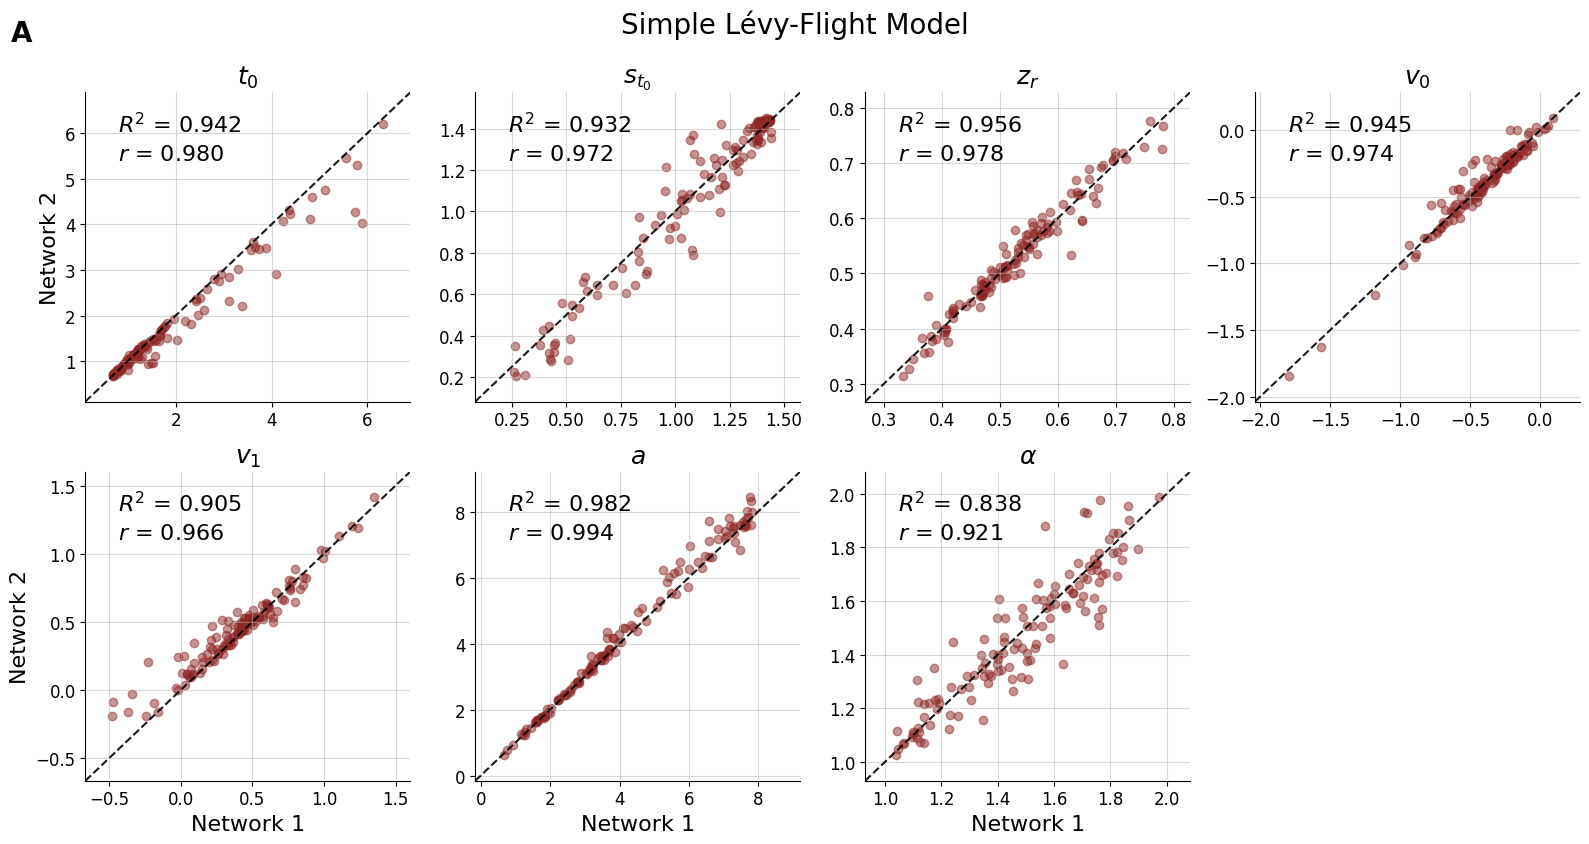

levy; Study 2


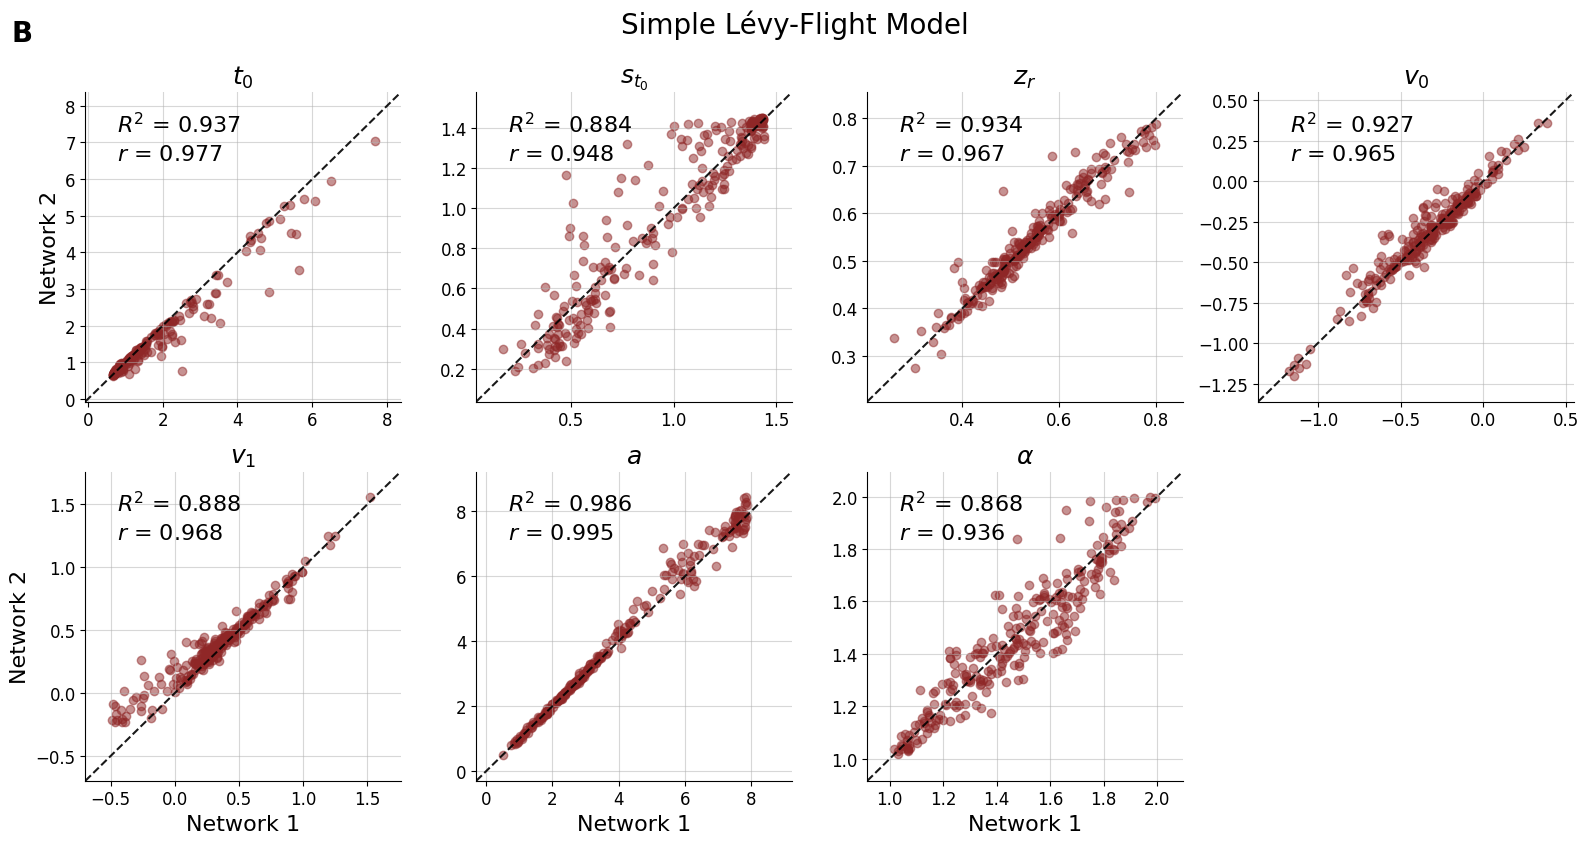

In [42]:
for study in range(NUM_STUDIES):
    for i, p in enumerate(PRIOR_CONTEXTS):
        for j, s in enumerate(SIMULATOR_CONTEXTS):
    
            net1_pred = pd.read_csv(ESTIM_ROOT_PATH +  f"{MY_NAME}_study{study+1}_tukey{tukey}_net1.csv")
            net2_pred = pd.read_csv(ESTIM_ROOT_PATH +  f"{MY_NAME}_study{study+1}_tukey{tukey}_net2.csv")

            net1_pred = net1_pred.drop(columns=['pp', 'file', 'cond', 'ans', 'att', 'acc'], axis=1)
            net2_pred = net2_pred.drop(columns=['pp', 'file', 'cond', 'ans', 'att', 'acc'], axis=1)
                   
            plot_ensemble_agreement(
                net1_estimates=np.array(net1_pred),
                net2_estimates=np.array(net2_pred),
                xlabel="Network 1",
                ylabel="Network 2",
                param_names=PARAM_LABELS,
                add_corr=True,
                add_r2=True,
                color="#8f2727",
                n_row=2,
                n_col=4
            )
            plt.suptitle(f'Simple {model_map.get(p)} Model', fontsize=20, y=1.05)
            annotation = "A" if study == 0 else "B"
            plt.figtext(0.01, 1.01, annotation, fontsize=20, ha='left', fontweight='bold')
    
            filename = FIG_PATH + f"/figB7_agreement_study{study+1}.png"
            plt.savefig(filename, transparent=False, bbox_inches='tight')
    
            print(f'{p}; Study {study + 1}')
            plt.show()

## Simulate RT Data

In [43]:
for network in range(NUM_ENSEMBLE_MEMBERS):
    for p in PRIOR_CONTEXTS:
        for study in range(NUM_STUDIES):
            DATA_PATH = DATA_ROOT_PATH + f"study{study+1}_tukey{tukey}/"
            my_path = f"{MY_NAME}_study{study+1}_tukey{tukey}_net{network + 1}.csv"
            estimates_path = ESTIM_ROOT_PATH + my_path
            simulates_path = SIM_ROOT_PATH + my_path
            
            if not os.path.exists(simulates_path):
                print("generating data for study", study+1)
                df = pd.read_csv(estimates_path)
                all_sim_data = pd.DataFrame()
                
                for i in range(len(df)):
                    theta = df[PARAM_NAMES].to_numpy(copy=True)[i] 
                    if p == 'ddm':
                        theta[6] = 2.0
                    sim_data = prior_simulator_functions.ddm_simulator(theta, 1000, deadline=False)
                    participant_sim_data = pd.DataFrame({
                        'rt': [row[0] for row in sim_data], 
                        'symbol': [row[1] for row in sim_data],
                        'cond': df['cond'][i],
                        'pp': df['pp'][i]
                    })
            
                    all_sim_data = pd.concat([all_sim_data, participant_sim_data])
                
                all_sim_data.reset_index(drop=True, inplace=True)
                all_sim_data.to_csv(simulates_path, index=False)
                print(f"saved simulates to {simulates_path}")
            else:
                print(f"{simulates_path} already exists")

mvct/simulates_param_estim_means/mvct_param_125ep_study1_tukey1.5_net1.csv already exists
mvct/simulates_param_estim_means/mvct_param_125ep_study2_tukey1.5_net1.csv already exists
mvct/simulates_param_estim_means/mvct_param_125ep_study1_tukey1.5_net2.csv already exists
mvct/simulates_param_estim_means/mvct_param_125ep_study2_tukey1.5_net2.csv already exists


# Mahalanobis Outliers

In [44]:
for study in range(NUM_STUDIES):
    for network in range(NUM_ENSEMBLE_MEMBERS):
        result_simulated = prepare_data("simulated", calculate_by_symbol=True, return_type="summary", 
                                                    network=network, study=study, tukey=1.5)
        result_empirical = prepare_data("empirical", calculate_by_symbol=True, return_type="summary", 
                                                    network=network, study=study, tukey=1.5)
        merged_data = pd.merge(result_empirical, result_simulated, on=['pp', 'symbol', 'cond'], suffixes=('_empirical', '_simulation'))
        merged_data['study'] = study+1
        
        import numpy as np
        import pandas as pd
        from scipy.stats import chi2
        from scipy.spatial.distance import mahalanobis
        
        data_empirical = result_empirical[result_empirical['cond'] == "control"]
        data_simulated = result_simulated[result_simulated['cond'] == "control"]
        merged_data = pd.merge(data_empirical, data_simulated, on=['pp', 'symbol', 'cond'], 
                                               suffixes=('_empirical', '_simulation'))
        
        qus = ['0.25_correct', '0.5_correct', '0.75_correct']
        vars = ["accuracy"] +  qus

        pcrit = 0.001  
        pps_exclude = set()
        
        # Compute Mahalanobis distances and identify outliers
        for var in vars:
            for symbol in [0, 1]:
                subset = merged_data[merged_data["symbol"] == symbol].copy()
        
                ma = pd.DataFrame({
                    "true": subset[f"{var}_empirical"],
                    "estim": subset[f"{var}_simulation"],
                    "pp": subset["pp"] 
                }).dropna()  
        
                if ma.shape[0] > 1:  
                    cov_matrix = np.cov(ma[["true", "estim"]].T) 
                    inv_cov_matrix = np.linalg.inv(cov_matrix) 
                    mean_values = np.mean(ma[["true", "estim"]], axis=0) 
                    ma["maha"] = ma.apply(lambda row: mahalanobis(row[["true", "estim"]], mean_values, inv_cov_matrix), axis=1)
                    ma["maha_p"] = 1 - chi2.cdf(ma["maha"], df=2)  
                    exclude_pps = ma.loc[ma["maha_p"] < pcrit, "pp"].unique()
                    pps_exclude.update(exclude_pps)

        pps_exclude = sorted(pps_exclude)
        
        print(f"Study {study+1}, net {network+1}, participants to exclude: {pps_exclude}")

Study 1, net 1, participants to exclude: []
Study 1, net 2, participants to exclude: []
Study 2, net 1, participants to exclude: []
Study 2, net 2, participants to exclude: []


# Scatterplots

In [45]:
my_font_size = 12
my_marker_size = 10
rt_max = 18

In [46]:
def plot_panel(ax, data, x, y, title, lims, 
               palette=base_palette, alpha=0.5, 
               hue="symbol",
               marker="o", marker_size=40, my_linestyle='-', xlabel="Empirical", ylabel="Predicted"):
    sns.scatterplot(
        data=data, x=x, y=y, style=hue, hue=None,      
        markers={0: "o", 1: "^"}, color="black",
        ax=ax, alpha=1,
        legend=False, s=marker_size
    )
    
    ax.plot(lims, lims, 'k-', lw=2)

        
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title, fontsize=my_font_size+2)
    if (x == "accuracy_empirical"):
        ax.xaxis.set_major_formatter(FuncFormatter(apa_tick_formatter(digits=2)))
        ax.yaxis.set_major_formatter(FuncFormatter(apa_tick_formatter(digits=2)))
        max_ticks = 5
    else:
        max_ticks = 5
    ax.xaxis.set_major_locator(MaxNLocator(nbins=max_ticks))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=max_ticks))
        
    ax.grid(True, axis='y', color='lightgrey', linestyle='-', linewidth=0.75, zorder=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.tick_params(
        axis='both', which='both', bottom=True, top=False, left=True, right=False, #length=5,  
        width=0.5, direction='out')

Network 1 , Study 1


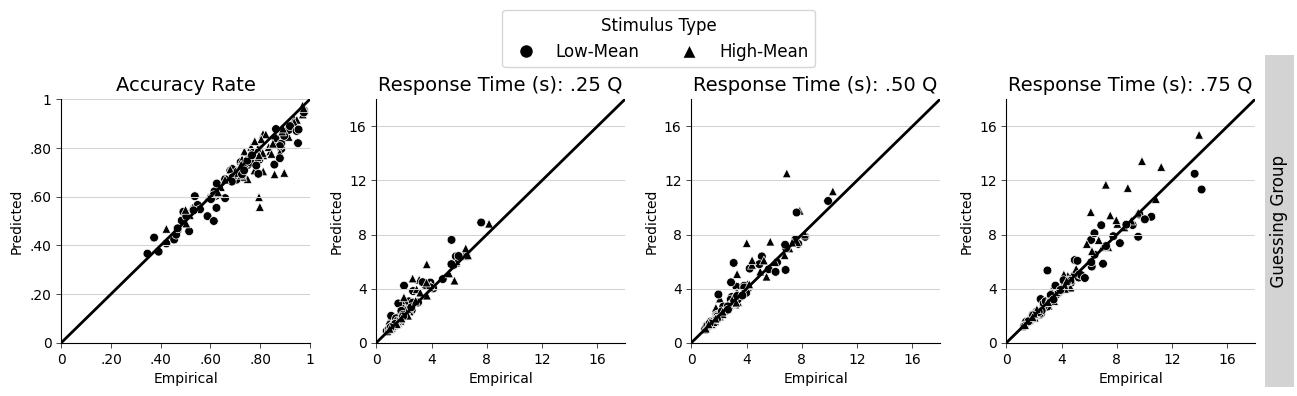

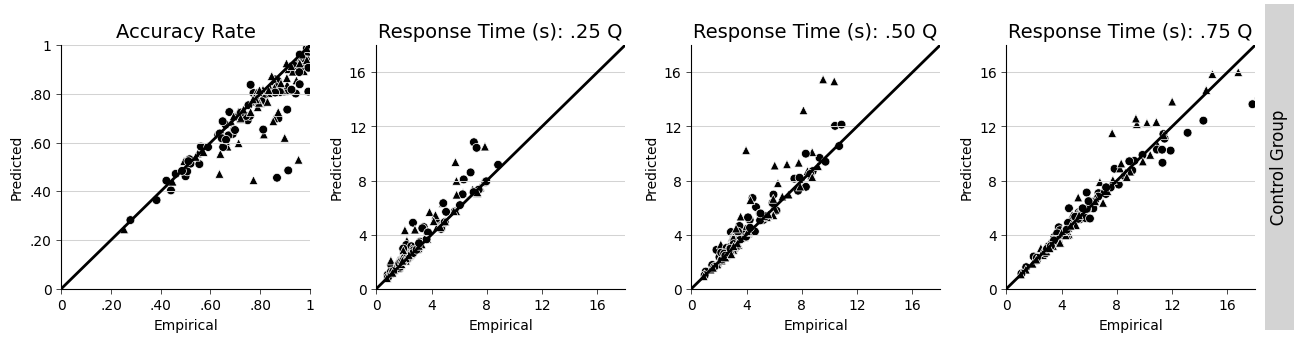

Network 2 , Study 1


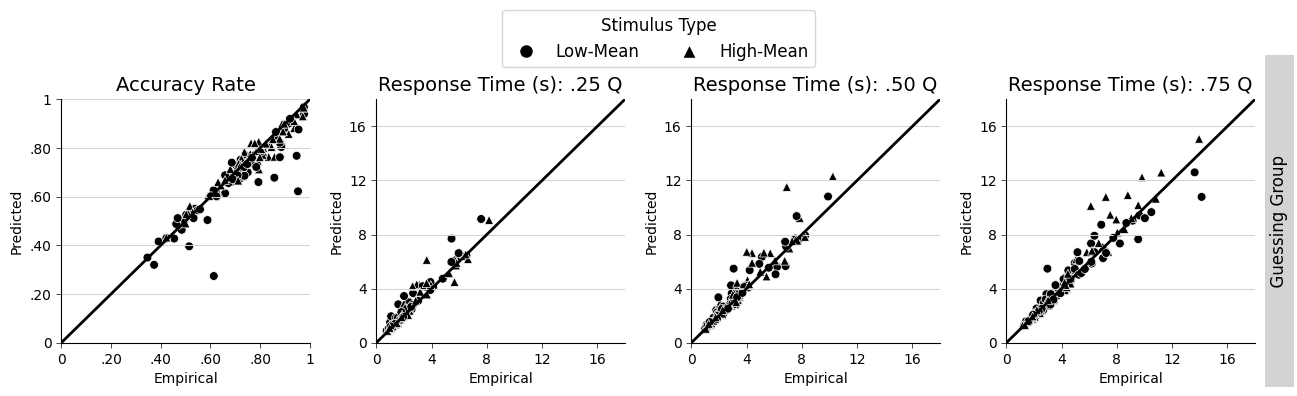

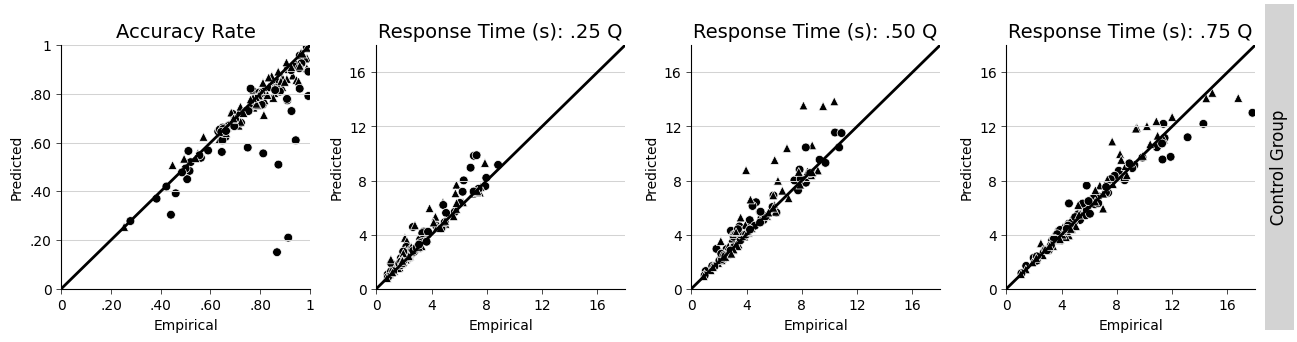

Network 1 , Study 2


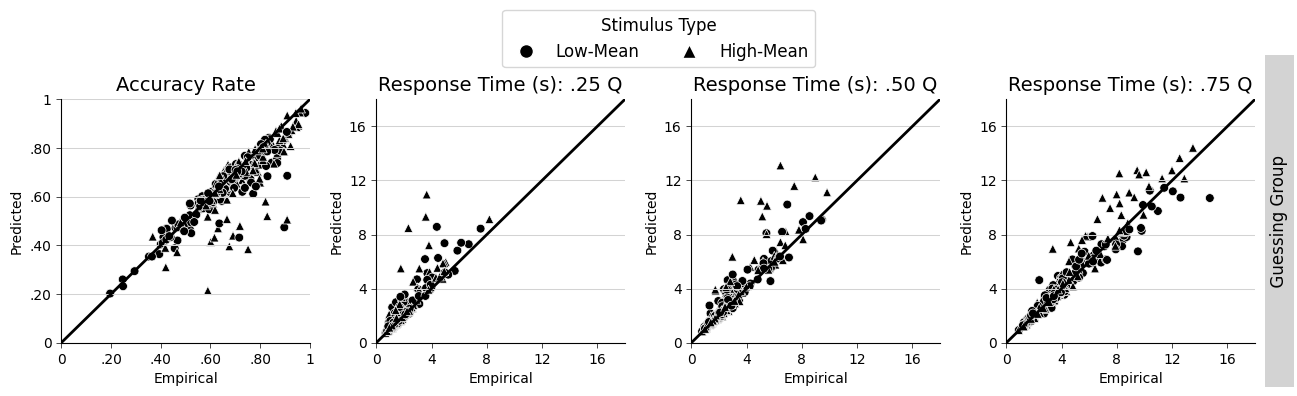

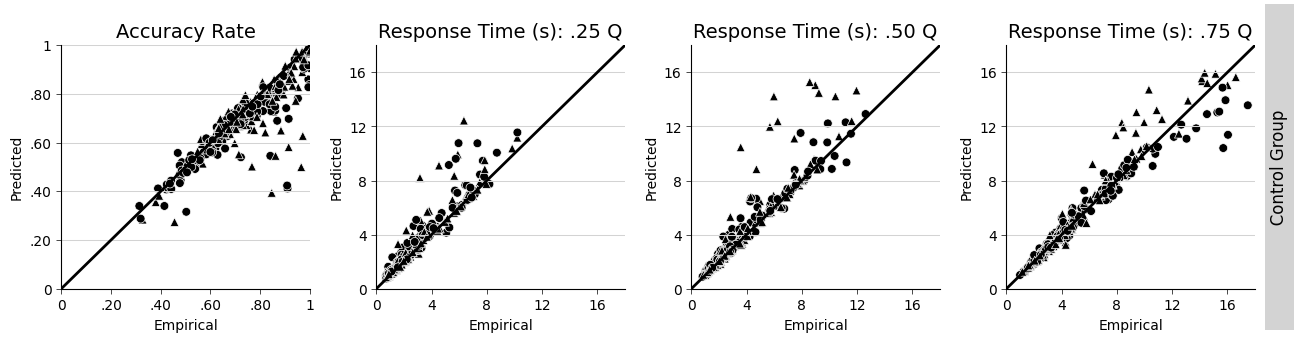

Network 2 , Study 2


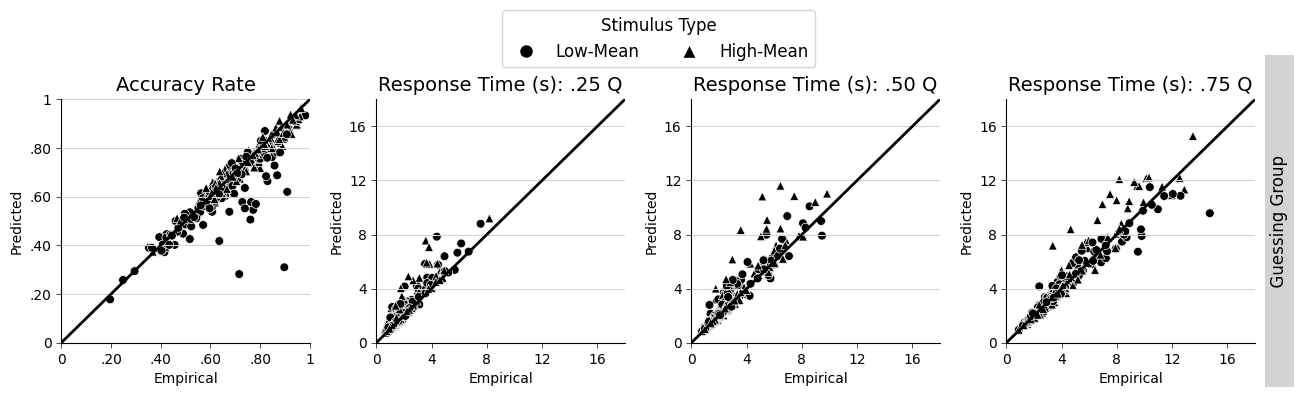

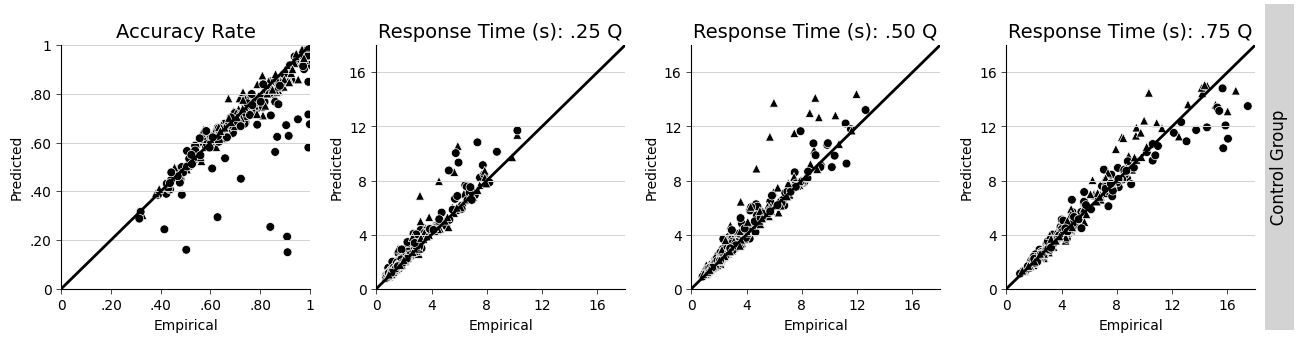

In [47]:
for study in range(NUM_STUDIES):
    for network in range(NUM_ENSEMBLE_MEMBERS):
        print("Network", network + 1, ", Study", study + 1)

        result_simulated = prepare_data(
            "simulated", calculate_by_symbol=True, return_type="summary",
            network=network, p=p, study=study, tukey=1.5
        )
        result_empirical = prepare_data(
            "empirical", calculate_by_symbol=True, return_type="summary",
            network=network, p=p, study=study, tukey=1.5
        )

        merged_data = pd.merge(
            result_empirical, result_simulated,
            on=['pp', 'symbol', 'cond'], suffixes=('_empirical', '_simulation')
        )
        merged_data['study'] = study + 1

        file_name = f"{MY_NAME}_study{study+1}_tukey{tukey}_net{network + 1}.csv"
        estimates_path = os.path.join(ESTIM_ROOT_PATH, file_name)
        df_study = pd.read_csv(estimates_path)

        quantile_labels = ['0.25', '0.5', '0.75']
        quantile_headings = ['.25', '.50', '.75']

        for cond in ['guess', 'control']:
            merged = merged_data[merged_data['cond'] == cond]
            fig, axs = plt.subplots(1, 4, figsize=(12.75, 4))

            # --- Accuracy ---
            plot_panel(
                axs[0], merged,
                x='accuracy_empirical',
                y='accuracy_simulation',
                title='Accuracy Rate', 
                lims=[0, 1]
            )

            # --- Correct RTs ---
            for i, q in enumerate(quantile_labels):
                emp_col = f'{q}_correct_empirical'
                sim_col = f'{q}_correct_simulation'
                if emp_col not in merged or sim_col not in merged:
                    continue
                label = f'Response Time (s): {quantile_headings[i]} Q'
                plot_panel(
                    axs[i+1], merged,
                    x=emp_col, y=sim_col,
                    title=label, lims=[0, rt_max]
                )
                
            spacer_map = {"control": " " * 19, "guess": " " * 18}
            spacer = spacer_map.get(cond, "")
            add_timeout = ""

            fig.text(
                1.0, 0.45,
                f"{spacer}{condition_map.get(cond)}{add_timeout}{spacer}",
                va='center', ha='left', rotation='vertical',
                bbox=dict(facecolor='lightgrey', edgecolor='none'),
                fontsize=my_font_size
            )
            fig.text(
                1.0, 0.45,
                f"{spacer}{condition_map.get(cond)}{add_timeout}{spacer}",
                va='center', ha='left', rotation='vertical',
                bbox=dict(facecolor='lightgrey', edgecolor='none'),
                fontsize=my_font_size
            )

            if cond == "guess":
                legend_items = [
                    mlines.Line2D(
                        [0], [0], marker='o', color='w', label="Low-Mean",
                        markerfacecolor="black", markersize=my_marker_size
                    ),
                    mlines.Line2D(
                        [0], [0], marker='^', color='w', label="High-Mean",
                        markerfacecolor="black", markersize=my_marker_size
                    )
                ]
                legend2 = fig.legend(
                    handles=legend_items, bbox_to_anchor=(.65, 0.999), ncol=2,
                    title='Stimulus Type', fontsize=my_font_size
                )
                legend2._legend_box.align = "center"
                plt.setp(legend2.get_title(), fontsize=my_font_size)

            plt.tight_layout(rect=[0, 0.0, 1, 0.85])
            
            plt.savefig(FIG_PATH + f"/fig3_scatter_study{study+1}_net{network+1}_{cond}.png", transparent=False, 
                        bbox_inches="tight", dpi=MY_DPI)
            plt.show()

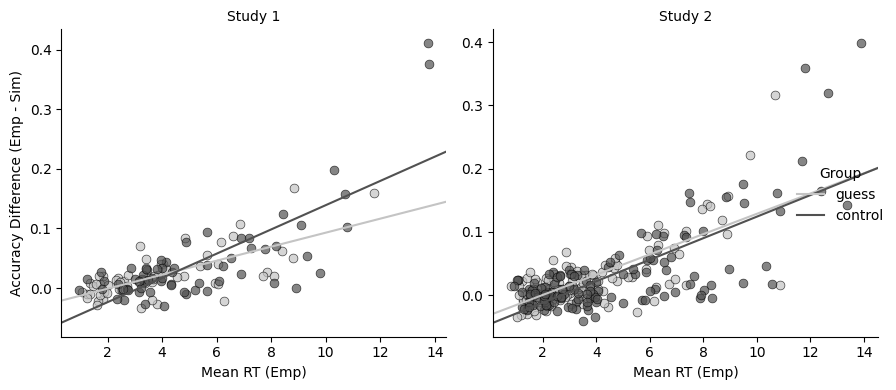

   study     cond     r       p
0      1  control  0.56  < .001
1      1    guess  0.59  < .001
2      2  control  0.57  < .001
3      2    guess  0.59  < .001


In [48]:
all_plot_df = []  

for study in range(NUM_STUDIES):

    result_simulated = prepare_data(
        "simulated", calculate_by_symbol=0, return_type="summary",
        network=1, p=p, study=study, tukey=1.5
    )
    result_empirical = prepare_data(
        "empirical", calculate_by_symbol=0, return_type="summary",
        network=1, p=p, study=study, tukey=1.5
    )
    
    merged_data = pd.merge(
        result_empirical, result_simulated,
        on=['pp', 'cond'], suffixes=('_empirical', '_simulation')
    )
    merged_data['acc_diff'] = (
        merged_data['accuracy_empirical'] - merged_data['accuracy_simulation']
    )
    
    plot_df = merged_data[
        ['pp', 'cond', 'acc_diff',
         'meanRT_correct_empirical', 'meanRTlog_correct_empirical']
    ].dropna()
    
    plot_df['study'] = study + 1  
    all_plot_df.append(plot_df)

plot_df_all = pd.concat(all_plot_df, ignore_index=True)

g = sns.FacetGrid(
    plot_df_all,
    col="study",
    hue="cond",
    palette=base_palette,  
    height=4,
    sharex=False,
    sharey=False
)

g.map_dataframe(
    sns.scatterplot,
    x="meanRT_correct_empirical",
    y="acc_diff",
    alpha=0.7,
    s=40,
    edgecolor="k"
)

g.map_dataframe(
    sns.regplot,
    x="meanRT_correct_empirical",
    y="acc_diff",
    scatter=False,
    ci=None,
    line_kws={"lw": 1.5},
    truncate=False
)

g.add_legend(title="Group")
g.set_axis_labels("Mean RT (Emp)", "Accuracy Difference (Emp - Sim)")
g.set_titles("Study {col_name}")

plt.tight_layout()
plt.show()

corrs_by_cond_study = (
    plot_df_all
    .groupby(["study", "cond"])
    .apply(lambda g: pearsonr(
        g["meanRTlog_correct_empirical"],
        g["acc_diff"]
    ))
    .reset_index(name="corr_tuple")
)

corrs_by_cond_study[["r", "p"]] = pd.DataFrame(
    corrs_by_cond_study["corr_tuple"].tolist(),
    index=corrs_by_cond_study.index
)

corrs_by_cond_study = corrs_by_cond_study.drop(columns="corr_tuple")
corrs_by_cond_study["r"] = corrs_by_cond_study["r"].round(2)

corrs_by_cond_study["p"] = corrs_by_cond_study["p"].apply(
    lambda x: "< .001" if x < 0.001 else f"{x:.3f}"
)

print(corrs_by_cond_study)

# Parameters

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

Network 1


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

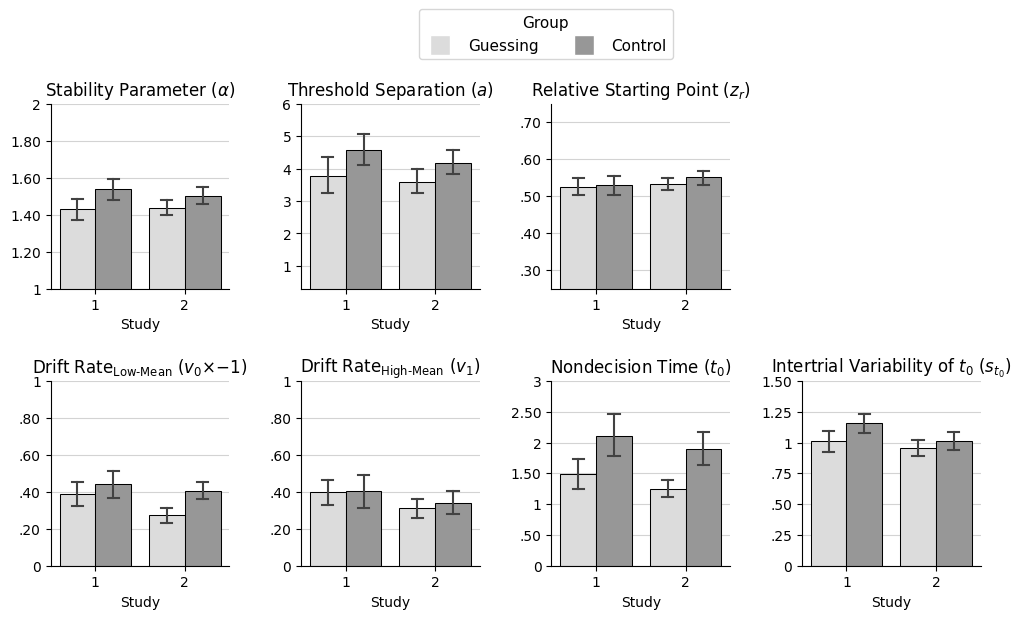

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

Network 2


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

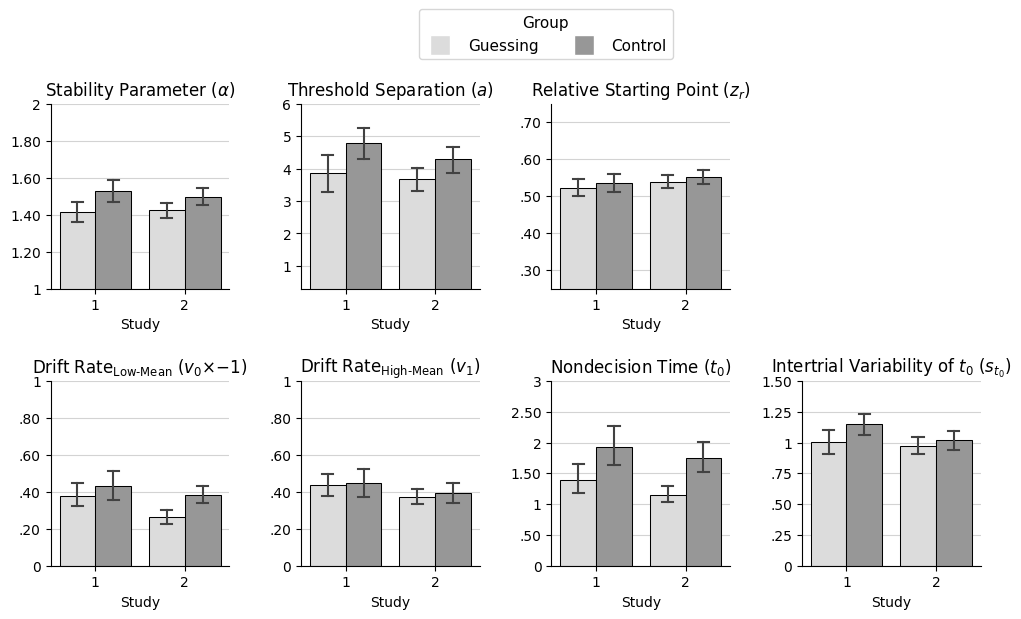

In [49]:
y0_y1_mappi = {'zr': [0.25, .75],
 'a': [0.3, 6.0],
 'v0': [-0, 1],
 'v1': [-0, 1],
 't0': [0, 3],
 'st0': [0.0, 1.5],
 'alpha': [1.0, 2]}

PARAM_NAMES_ordered = ['alpha', 'a', 'zr', 'v0', 'v1', 't0', 'st0']
fancy_PARAM_LABELS = [
    r"Stability Parameter ($\alpha$)",
    r"Threshold Separation ($a$)",
    r"Relative Starting Point ($z_r$)", 
    r"Drift Rate$_{\text{Low-Mean}}$ ($v_{0}$×−1)", 
    r"Drift Rate$_{\text{High-Mean}}$ ($v_{1}$)",
    r"Nondecision Time ($t_0$)", 
    r"Intertrial Variability of $t_0$ ($s_{t_0}$)"
]

my_marker_size = 15

for network in range(NUM_ENSEMBLE_MEMBERS):
    print("Network", network+1)
    
    for p in PRIOR_CONTEXTS:
        df_list = []
        for study in range(NUM_STUDIES):
            file_name = f"{MY_NAME}_study{study+1}_tukey{tukey}_net{network + 1}.csv"
            estimates_path = os.path.join(ESTIM_ROOT_PATH, file_name)
            if os.path.exists(estimates_path):
                df_study = pd.read_csv(estimates_path)
                df_study["study"] = study + 1
                df_list.append(df_study)

        df = pd.concat(df_list, ignore_index=True)
        df["study"] = df["study"].astype(int)
        df['v0'] = df['v0'] * -1

        fig = plt.figure(figsize=(12, 6))
        gs = gridspec.GridSpec(2, 4, figure=fig, wspace=0.4, hspace=0.5)

        axes = []
        subplot_indices = [0, 1, 2, 4, 5, 6, 7]  
        for idx in subplot_indices:
            ax = fig.add_subplot(gs[idx])
            axes.append(ax)

        for i, (param, label) in enumerate(zip(PARAM_NAMES_ordered, fancy_PARAM_LABELS)):
            ax = axes[i]
            ax.grid(True, which='major', axis='y', color='lightgrey', zorder=0)

            sns.barplot(
                x='study', y=param, data=df, hue="cond", capsize = 0.25,  err_kws={'linewidth': 1.5},
                palette=palette, ax=ax, zorder=2,
                hue_order=["guess", "control"], 
                linewidth=0.75, edgecolor="black")

            ax.set_title(label)
            ax.set_xlabel('Study')
            ax.set_ylabel('')
            ax.set_xticks(ax.get_xticks())
            ax.set_xticklabels(["1", "2"])

            ax.yaxis.set_major_formatter(FuncFormatter(apa_tick_formatter(digits=2)))
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)

            if param in PARAM_NAMES_ordered:
                 ax.set_ylim(y0_y1_mappi[param])

            if ax.get_legend() is not None:
                ax.get_legend().remove()

        legend_items = [
            mlines.Line2D([0], [0], marker='s', color='w', label="Guessing",
                          markerfacecolor=palette['guess'], markersize=my_marker_size),
            mlines.Line2D([0], [0], marker='s', color='w', label="Control",
                          markerfacecolor=palette['control'], markersize=my_marker_size)
        ]
        legend2 = fig.legend(
            handles=legend_items, bbox_to_anchor=(.65, 1.05), ncol=2,
            title='Group', fontsize=11
        )
        plt.setp(legend2.get_title(), fontsize=11)
        plt.savefig(FIG_PATH + f"/fig4_params_net{network+1}.png", transparent=False, 
                       bbox_inches="tight", dpi=MY_DPI)

        plt.show()